# ANALISIS DE RIESGOS: Airplane

En este notebook se crea un modelo para el AAP dadas las características del avión.

In [1]:
#  Manejo de datos
import pandas as pd

#  Análisis de datos
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelado
from pycaret.classification import *
import xgboost

#  Auxiliares
# Fecha y hora
from datetime import datetime
#  Numéricos
import numpy as np
#  Texto
import re
# Uso de modelos
import joblib

#  Representaciones gráficas
#  Graficos
import matplotlib.pyplot as plt
#  Mapas
import geopandas
import folium
from folium import plugins

## OBTENCIÓN DE DATOS

A continuación se carga en un dataframe los datos extraídos de la fuente de estudio guardados en formato parquet por su gran volumen de datos.

In [2]:
# Directorio de los datos
data_dir = 'Datasets/PHA/'
pha_file = 'PHA_Data2.parquet'
legend_file = 'column_info.csv'
model_info_dir = 'Airplane/'

In [3]:
# Lectura del fichero .parquet creado todo el conjunto de datos
data_df = pd.read_parquet(data_dir + pha_file, engine='pyarrow')

# Dataframe y diccionario leyenda de las columnas
df_legend = pd.read_csv(data_dir + legend_file, sep=';')
leyend_dict = dict(zip(df_legend['Column_name'], df_legend['Description']))

## EXPLORATORY DATA ANALYSIS (EDA)

<h4><div style="font-size:14px; text-align:center"><b>REDUCCIÓN DE DIMENSIONALIDAD</b><br></div></h4>

Dado que el numero de columnas es elevado y alguna de estas no aporta información a nuestro caso de estudio, se realiza primero la selección de los atributos de estudio dejando así un dataframe que sea más reducido en cuanto a sus atributos de partida para poder trabajar el analisis de datos con mayor facilidad.

<h5><div style="font-size:14px; text-align:left"><b>CORRELACION DE ATRIBUTOS</b><br></div></h5>

<p>Como primer estudio para ver la relación de los datos y ayudarnos a tomar la decisión de los atributos a seleccionar, se observa la relación de las columnas de forma gráfica. Esto es, la dependencia que tiene una columna con repecto a las otras si estas varian.</p>
<p>Para este estudio, se emplea el metodo <i>corr</i> de Pandas. Pero, previamente se requiere codificar las variables no numéricas ya que esta función, únicamente actúa sobre las columnas numéricas, y es este momento, queremos ver la relación de todas las columnas. Para ello, se hace uso del modulo <i>preprocessing</i> de <b>scikit-learn</b>. Con este modulo se puede hacer uso de métodos que nos permitirá codificar los atributos categóricas a numéricos.<br>
    Se utiliza el encoder <b>OrdinalEncoder</b> que transforma el valor en el ordinal para la columna, dando como resultado valores numericos de 0 a n-1 caracterisitica.</p>

In [4]:
# Instancia del codificador
oe = OrdinalEncoder()

# Ajuste del modelo (fit) y codificación de los datos (transform)
oe.fit(data_df)
data_encoded = oe.transform(data_df)

# Crear un dataframe auxiliar con los atributos y valores transformados
names = oe.get_feature_names_out()
df_encoded = pd.DataFrame(data_encoded, columns=names)
df_encoded

,c1,c6,c7,c8,c10,c132,c134,c136,c138,c141,...,c150,c154,c156,c158,c161,c163,c183,c191,c229,c230
0,0.0,0.0,0.0,0.0,0.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,13.0,33.0,33.0,1.0,1.0,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,13.0,33.0,33.0,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214627,1.0,47.0,1.0,5.0,1036.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,5333.0,NaN
214628,1.0,47.0,1.0,6.0,910.0,26.0,17.0,26.0,14.0,9.0,...,2.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,3627.0,NaN
214629,1.0,47.0,0.0,30.0,515.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,6690.0,1284.0
214630,1.0,47.0,0.0,6.0,249.0,26.0,17.0,26.0,14.0,9.0,...,3.0,2.0,11.0,12.0,33.0,33.0,1.0,1.0,2137.0,NaN


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Atributos mapeados a numéricos</i></div>

In [5]:
corr = df_encoded.corr()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Matriz de correlacion de atributos.</i></div>

In [6]:
# Eliminar la diagonal principal y los valores debajo de esta, manteniendo solo los valores superiores
# para ver solo valores unicos diferentes de 1 (relacion con diferentes atributos)
corr_filter = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))

# Ordenar de mayor a menor
corr_sort = corr_filter.stack().sort_values(ascending=False).to_frame()

# Añadir nombres a las columnas para entender las relaciones
corr_sort = corr_sort.rename(columns=leyend_dict, index=leyend_dict)

corr_sort.head(60)

0
Including crew and passengers.                     Number of passengers onboard                        0.999323
Region of the air operator                         District office of the air operator                 0.994042
Region of the accident/incident location.          District office of the accident/incident location.  0.986868
Under or over 750 hp.                              Type of engine.                                     0.967705
Type of the engine code.                           Piston, turbine, turboprop, etc.                    0.961411
Residence region code of the pilot in command      Residence district office code of the pilot in ...  0.958638
Under or over 750 hp.                              Type of the engine code.                            0.951818
Type of the engine code.                           Type of engine.                                     0.947610
                                                   Text for element C153.                              0.940706
Latitude coordinates of the accident/incident      Longitude coordinates of the accident/incident      0.939672
Second remedial action area code                   Second remedial action area text                    0.938831
                                                   Second remedial action taken code                   0.932883
Number of passengers injured                       All injuries including crew passengers and public.  0.929672
Second persons involved code                       Supporting cause factor B code.            OPER...  0.926089
Number of passengers killed                        Total Fatalities                                    0.924393
Second remedial action taken code                  Second remedial action area text                    0.921919
Persons involved code                              Supporting cause factor A code.            OPER...  0.918526
Piston, turbine, turboprop, etc.                   Type of engine.                                     0.914090
Under or over 750 hp.                              Piston, turbine, turboprop, etc.                    0.913491
Second persons involved code                       Second contributing factor text                     0.906579
Piston, turbine, turboprop, etc.                   Text for element C153.                              0.900744
Code for Weight  Class                             Code representing typical engine design charact...  0.899907
Powered, Nonpowered, Optional                      Text for element C150                               0.899238
Supporting factor code                         ... Supporting factor text                         ...  0.895835
Code for Aircraft Design                           Code for Weight  Class                              0.892309
Wing information of the aircraft involved in th... Powered, Nonpowered, Optional                       0.887106
Persons involved code                              Persons involved text                               0.884604
Supporting cause factor A code.            OPER... Persons involved text                               0.880026
Supporting cause factor B code.            OPER... Second contributing factor text                     0.879615
Powered, Nonpowered, Optional                      Wing information of the aircraft text               0.877735
Under or over 750 hp.                              Certificating region of the engine                  0.876036
Persons involved code                              Contributing factor text                            0.873580
Code for Weight  Class                             Powered, Nonpowered, Optional                       0.871131
Type of the engine code.                           Certificating region of the engine                  0.867151
Code for Aircraft Design                           Wing information of the aircraft involved in th...  0.862308
Including crew and passengers.                     Number of cabin crew member

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>60 primeras correlaciones.</i></div>

<p>Las primeras 60 correlaciones que se obtiene hace referencia a atributos que no son relevantes para el caso de estudio de este modelo. Como se ve, en gran parte hace referencia a personas muertas o heridas en los sucesos, dando una gran correlacion a las personas tripulantes y pasajeros, que por razones obvias, se tiene una gran correlación.<br>
    Para seguir con el estudio de la correlación, se muestra otro fragmento de resultados.</p>

In [7]:
# Siguientes 60 resultados
corr_sort.iloc[60:120]

0
Wing information of the aircraft involved in th... Text for element C150                               0.774315
Total number of hours in the last 90 days the p... Total number of hours in the last 90 days the p...  0.770035
Primary type of flying code                        Light condition text                                0.767864
Primary flying condition code                      General cause category code                         0.767055
                                                   Light condition text                                0.764489
Wing information of the aircraft text              Text for element C150                               0.762557
Primary type of flying code                        Secondary type of flying code                       0.762071
Second remedial action area text                   Second remedial action taken text                   0.759773
Certificate number of the air agency               District office of the air operator                 0.758527
Primary type of flying code                        General cause category code                         0.752803
Secondary cause factor code                        Second cause factor text                            0.751669
Year the accident/incident happened.               Qualification code of the pilot in command .        0.749654
General cause category code                        General cause category text                         0.742463
Powered, Nonpowered, Optional                      Code representing typical engine design charact...  0.737785
Second supporting factor code .               T... Second cause factor text                            0.737173
Second remedial action area code                   Second remedial action taken text                   0.734144
Make of the engine                                 Model of the engine                                 0.733539
Certificate number of the air agency               Region of the air operator                          0.729337
Powered, Nonpowered, Optional                      Aid Text                                            0.725437
Second contributing case code f                    Second persons involved code                        0.721491
Code for Weight  Class                             Text for element C150                               0.720319
Wind direction                                     Wind speed in miles per hours                       0.713165
Wing information of the aircraft involved in th... Code representing typical engine design charact...  0.712267
Code for Aircraft Design                           Powered, Nonpowered, Optional                       0.711308
Code representing typical engine design charact... Wing information of the aircraft text               0.708104
Wing information of the aircraft involved in th... Low wing, high wing, rotary wing, etc.              0.707712
Group of the aircraft                              Region of certification for the aircraft            0.705206
Primary type of flying code                        Type of accident code                               0.699540
Second cause factor text                           Second supporting factor text                  ...  0.696256
Contributing factor code                           Contributing factor text                            0.695077
Under or over 750 hp.                              Make of the engine                                  0.693409
Primary type of flying code                        Rating description of the pilot in command          0.691318
Primary type of flying text                        Secondary type of flying text                       0.687773
State of the owner / operator                      Certificate number of the air agency                0.685689
Second contributing case code f                    Supporting cause factor B code.            OPER...  0.684940
Code for Aircraft Design                           Number of engines on aircra

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Segundo grupo de correlaciones.</i></div>

<p>Las siguientes correlaciones, ya aporta un mayor numero de relaciones interresantes para el estudio del modelo. Se puede extraer que las <b>Primary flying condition</b> tienen una importante correlación con el resultado del suceso.<br>
    Además, se observa que atributos climáticos como <b>velocidad y direccion del viento</b> toman relevancia en la relación de atributos.<br>
    También se observa que el tipo de vuelo y la calificación del piloto tienen cierta relación. Esto se considera interesante ya que se entiende de la calificación/experiencia de un piloto puede ser determinante en determinadas situaciones climáticas.<br>
    Para seguir con el estudio de la correlación, se muestra otro fragmento de resultados.</p>

In [8]:
# Siguientes 60 resultados
corr_sort.iloc[120:180]

,,0
Rating description of the pilot in command,Any other rating description of the pilot in command,0.642714
State of the owner / operator,Region of the air operator,0.642538
Secondary flying condition code,Secondary flying condition text,0.642386
General cause category code,Primary flying condition text,0.642002
Year the accident/incident happened.,Primary type of flying code,0.641547
Make of the engine,"Piston, turbine, turboprop, etc.",0.636072
Primary flying condition code,Type of accident code,0.634840
Qualification code of the pilot in command .,Light condition text,0.631921
Supporting cause factor A code. OPERATIONAL,Supporting Factor Text OPERATIONAL,0.627560
Code for Aircraft Design,"Low wing, high wing, rotary wing, etc.",0.622389


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Tercer grupo de correlaciones.</i></div>

<h5><div style="font-size:14px; text-align:left"><b>SELECCIÓN DE ATRIBUTOS</b><br></div></h5>

<p>Teniendo en cuenta las correlaciones y el modelo de datos necesario para la predicción, las columnas seleccionadas han sido decididas en base a:
<ul>
    <li>Condiciones de construcción del aeroplano.</li>
    <li>Tipo y número de motores del aeroplano.</li>
    <li>Potencia de los motores.</li>
</ul>
</p>

In [9]:
def col_name(col: str):
    """
    Nombre de la columna
    """
    return df_legend[df_legend["Column_name"] == col]["Description"].values[0]

def clean_data(value):
    """
    Limpieza de los datos None a NaN. Si es un String, eliminar espacios finales e iniciales
    """
    # Si se trata de un valor en blanco sustituir a NaN
    try:
        # si es un string, eliminar espacios
        if isinstance(value, str):
            value = value.strip()
        
        if value in [None, 'nan', 'N/A', pd.NA]:
            return np.NaN
        
        return value

    except Exception as e:
        return value

In [10]:
# Columnas seleccionadas

columns = ['c1','c144','c145','c147','c149','c151','c153','c155','c157','c30', 'c31', 'c33', 'c34', 'c35', 'c36', 'c38', 
           'c39', 'c102','c104' ]

for col in columns:
    print(f'[+] SELECTED_COL\t{col}\t{col_name(col)}')

# Eliminar columnas indeseadas
df = data_df.drop(columns=[col for col in data_df.columns if col not in columns]).copy()
    
# Iterar sobre todas las columnas y comprobar sus valores
columns = len(df.columns)
print('\n')

for column in df.columns:
    # Utilizar compresion de listas y aplicar el filtrado de valores
    values = [clean_data(value) for value in df[column]]
    df[column] = values
    columns -= 1
    print(f'[+] REMAINING_CLEANING\t{columns}\t', end='\r')
print(' '*50)
    
df

[+] SELECTED_COL	c1	Type of Event
[+] SELECTED_COL	c144	Code for Aircraft Design
[+] SELECTED_COL	c145	Code for Weight  Class
[+] SELECTED_COL	c147	Wing information of the aircraft involved in the investigation.
[+] SELECTED_COL	c149	Powered, Nonpowered, Optional
[+] SELECTED_COL	c151	Number of engines on aircraft
[+] SELECTED_COL	c153	Under or over 750 hp.
[+] SELECTED_COL	c155	Type of the engine code.
[+] SELECTED_COL	c157	Type of Landing Gear code.
[+] SELECTED_COL	c30	Airworthiness class code of the aircraft
[+] SELECTED_COL	c31	Airframe hours of the aircraft
[+] SELECTED_COL	c33	Low wing, high wing, rotary wing, etc.
[+] SELECTED_COL	c34	Make of the engine
[+] SELECTED_COL	c35	Model of the engine
[+] SELECTED_COL	c36	Group of the engine
[+] SELECTED_COL	c38	Certificating region of the engine
[+] SELECTED_COL	c39	Piston, turbine, turboprop, etc.
[+] SELECTED_COL	c102	Primary type of flying code
[+] SELECTED_COL	c104	Secondary type of flying code


                                  

,c1,c144,c145,c147,c149,c151,c153,c155,c157,c30,c31,c33,c34,c35,c36,c38,c39,c102,c104
0,A,1L71,1,L,7,1,NaN,NaN,NaN,STRD,NaN,L,NaN,NaN,NaN,NaN,NaN,1,N
1,A,1H71,1,H,7,1,NaN,NaN,TR,STRD,NaN,H,NaN,NaN,NaN,NaN,NaN,1,K
2,A,1H71,1,H,7,1,NaN,NaN,TR,NaN,NaN,H,NaN,NaN,NaN,NaN,NaN,8,F
3,A,1H71,1,H,7,1,NaN,NaN,TR,NaN,NaN,H,NaN,NaN,NaN,NaN,NaN,1,N
4,A,1H71,1,H,7,1,NaN,NaN,NaN,STRD,NaN,H,NaN,NaN,NaN,NaN,NaN,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214627,I,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,TR,NaN,929.0,NaN,CONT M,O-200A,NaN,NaN,NaN,NaN,NaN
214628,I,1L71,1,L,7,1,NaN,NaN,TR,STRD,1823.0,NaN,CONT M,TSIO-550 SER,NaN,NaN,NaN,NaN,NaN
214629,I,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,TR,STRD,970.0,NaN,LYCOMI,IO-360-B1G6,NaN,NaN,NaN,NaN,NaN
214630,I,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,TR,STRD,NaN,NaN,GARRET,TPE331-12UHR,NaN,NaN,NaN,NaN,NaN


In [11]:
df1 = df.copy()

In [12]:
#df['c151'] = df['c151'].map(lambda x: int(float(x)))          # Número de motores
#df['c31'] = df['c31'].map(lambda x: int(float(x)))   
df['c151'].value_counts()

1    140051
2     42799
3      4723
0      2948
4      1937
Name: c151, dtype: int64

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Caracteristicas seleccionadas.</i></div>

<h4><div style="font-size:14px; text-align:center"><b>ANÁLISIS CONJUNTO DE DATOS</b><br></div></h4>

<p>Para tener un contexto de los datos que se tiene, se realiza una serie de visualización de datos.</p>
<p>La primera de estas acciones consiste en describir los datos que tenemos, en su tipo y cuántos de estos datos son válidos, o al menos, no desconocidos (NaN)</p>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214632 entries, 0 to 214631
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   c1      214632 non-null  object
 1   c144    192490 non-null  object
 2   c145    192490 non-null  object
 3   c147    192490 non-null  object
 4   c149    192490 non-null  object
 5   c151    192458 non-null  object
 6   c153    76706 non-null   object
 7   c155    76706 non-null   object
 8   c157    80559 non-null   object
 9   c30     40139 non-null   object
 10  c31     120345 non-null  object
 11  c33     170845 non-null  object
 12  c34     105407 non-null  object
 13  c35     104502 non-null  object
 14  c36     81809 non-null   object
 15  c38     76390 non-null   object
 16  c39     73150 non-null   object
 17  c102    173389 non-null  object
 18  c104    173307 non-null  object
dtypes: object(19)
memory usage: 31.1+ MB


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Descripción de los datos.</i></div>

De forma gráfica, y desde el concepto de porcebtaje de valores NaN en las columnas, se muestra el siguiente gráfico.

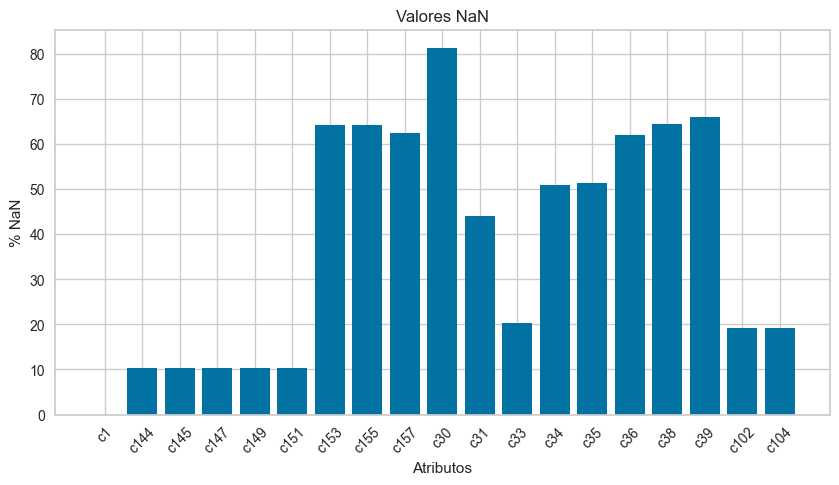

In [14]:
def plot_nan(df):
    """
    Imprimir el porcentaje de valores faltantes
    """
    def df_info_perc(df) -> dict:
        """
        Obtener el porcentaje de datos faltantes para plotear
        """
        # Diccionario con datos
        info_dic = {}
        # Numero de datos faltantes para las diferentes columnas
        rows = len(df)
        # print('\tCOLUMN\tNAN\tPERC')
        for col in df:        
            nan_values = df[col].isna().sum()
            perc = round((nan_values/rows) * 100, 2)
            # print(f'[+]\t{col}\t{nan_values}\t{perc}%')

            # Almacenar datos descriptivos
            info_dic.update({col: perc})

        return info_dic
    # Describir los datos faltantes
    info = df_info_perc(df)

    # Mostrar informacion
    plt.figure(figsize=(10, 5))
    plt.bar(info.keys(), info.values())
    plt.xlabel('Atributos')
    plt.xticks(rotation=45)
    plt.ylabel('% NaN')
    plt.title('Valores NaN')

    plt.show()
    
plot_nan(df)

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Porcentaje de valores NaN.</i></div>

El modelo que se desea realizar, debe de ser capaz de predecir el tipo de incidente que ocurrirá. Para ver si tenemos unos datos balanceados, a continuación se muestra una gráfica de la predicción a realizar, en donde podemos observa que si existe un balance de datos.

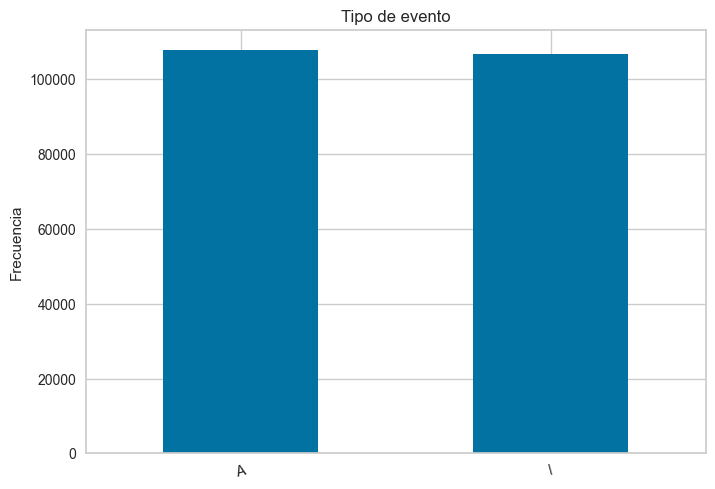

In [15]:
ax = df.c1.value_counts().plot(kind='bar', title='Tipo de evento')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Balanceo de clases.</i></div>

<p>A continuación se muestra el balanceo de datos para la columna del tipo de propósito del vuelo.</p>

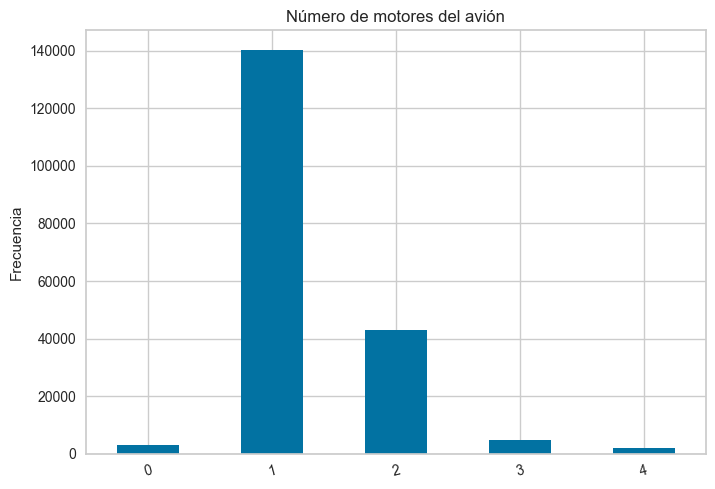

In [16]:
# Obtener la serie de conteos y ordenar los índices alfabéticamente
serie_counts = df.c151.value_counts().sort_index()

# Reordenar los valores de la serie según el nuevo orden de los índices
serie_counts = serie_counts.reindex(serie_counts.index.sort_values())

# Generar el gráfico de barras
ax = serie_counts.plot(kind='bar', title='Número de motores del avión')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Grafico: </b>Frecuencia de sucesos por mes.</i></div>

<h4><div style="font-size:14px; text-align:center"><b>DESCRIPCIÓN DE VALORES</b><br></div></h4>

Dado el elevado numero de datos faltantes y sabiendo que existe valores que están en columnas diferentes por el estudio realizado para obtener el dataset de trabajo. A continuación se detalla los valores que existe para cada uno de los atributos del modelo de datos obtenido.

In [17]:
# Iterar las columnas y mostrar los valores únicos
for col in df:
    print(f"[+] {col}\t{col_name(col)}")
    print(f"VALUES\t{df[col].unique()}\n")

[+] c1	Type of Event
VALUES	['A' 'I']

[+] c144	Code for Aircraft Design
VALUES	['1L71' '1H71' '2L72' '2L74' nan '1L72' '1G71' '1H72' '1K00' '1Q71' '2M74'
 '2H72' '2G71' '1B00' '2M72' '2L73' '2G72' '1K71' '1M71' '1G72' '2H71'
 '2H73' '1L74' '1H73' '2H74' '2Q73' '1B72' '1D71' '2L71' '1M72' '2D74'
 '1G00' '1H74' '1B71' '1K72' '1H81' '2X74' '2M71' '2S72' '1L00' '1H00'
 '2D71' '2Q72' '1X72' '1K0' '1B0' '1S71' '1W71' '1F71' '1K7' '1L73' '1X71'
 '1P71' '1E71' '1K01']

[+] c145	Code for Weight  Class
VALUES	['1' '2' nan]

[+] c147	Wing information of the aircraft involved in the investigation.
VALUES	['L' 'H' nan 'G' 'K' 'Q' 'M' 'B' 'D' 'X' 'S' 'W' 'F' 'P' 'E']

[+] c149	Powered, Nonpowered, Optional
VALUES	['7' nan '0' '8']

[+] c151	Number of engines on aircraft
VALUES	[1 2 4 <NA> 0 3]

[+] c153	Under or over 750 hp.
VALUES	[nan '3' '4']

[+] c155	Type of the engine code.
VALUES	[nan 'O' 'F' 'R' 'T' 'U' 'J' 'I' 'V' '1' 'X' '0' 'B' 'W']

[+] c157	Type of Landing Gear code.
VALUES	[nan 'TR' '

<h4><div style="font-size:14px; text-align:center"><b>CONCLUSIÓN</b><br></div></h4>

<p>Como se puede observar, existe la mitad de columnas que contiene más del 50% de datos nulos o vacíos que habrá que tener en cuenta a la hora de la selección de caracteristicas para nuestro estudio.</p>
<p>Se observa que la clase de estudio (Accidente o Incidente) está balanceada.</p>

## DATA PREPROCESSING (DP)

<h3><div style="font-size:14px; text-align:center"><b>IMPUTACION DE VALORES</b><br></div></h3>

Hasta ahora, se ha marcado todos los valores perdidos indicándolos como NaN. Ahora, para poder realizar el modelo de Machine Learing, se realiza una serie de estratégias para tratar con estos valores. Mediante la eliminación de instancias o imputación de valores.

In [18]:
def categorical_histogram(col: str, df: pd.DataFrame = df, bins=10):
    # Instancia del codificador
    oe = OrdinalEncoder()

    # Ajuste del modelo (fit) y codificación de los datos (transform)
    try:
        oe.fit(df[[col]])
        col_encoded = oe.transform(df[[col]])
    except:
        oe.fit(df[[col]].astype(str))
        col_encoded = oe.transform(df[[col]].astype(str))

    # Crear un dataframe auxiliar con los atributos y valores transformados
    names = oe.get_feature_names_out()
    col_df = pd.DataFrame(col_encoded, columns=names)

    # Imprimir el histograma de los datos
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

    col_df.plot(kind='box', ax=axes[0]).set_title('Distribución de los datos.')
    col_df.plot.hist(bins=bins, ax=axes[1])

    plt.show()
    
    print('[+] VALUES_ENCODED\t', oe.categories_[0])
    print('[+] SKEW\t', col_df.skew()[0])
    
def numerical_histogram(col: str, df: pd.DataFrame = df, bins=10):
    # Imprimir el histograma de los datos
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

    df[col].plot(kind='box', ax=axes[0]).set_title('Distribución de los datos.')
    df[col].plot.hist(bins=bins, ax=axes[1])

    plt.show()
    print('[+] SKEW\t', df[[col]].skew()[0])
    

#### Previamente se ha realizado un estudio y comprobado que existen una seria de filas con valores nulos comunes en varias columnas por lo que eliminamos esas filas para evitar imputaciones ya que el dataset es suficientemente grande.
#### Para ello utilizamos la columna c151 que es el número de motores del avión.

In [19]:
# Primero se convierten los 0 en NaN
df['c151'] = df['c151'].map(lambda x: np.nan if x is pd.NA or x == 0 else x)
df = df.dropna(subset=["c151"])

<h6><div style="font-size:14px; text-align:left"><b>c144: Code for Aircraft Design</b></div></h6>

In [20]:
col = 'c144'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isnull().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Code for Aircraft Design 

[+] NAN_VALUES	0	0.0 %


,c144
count,189510
unique,46
top,1H71
freq,72438


Al tratarse de una columna categórica, se realiza una codificación de los datos para poder ver la distribución de estos y poder decidir una técnica de imputación.

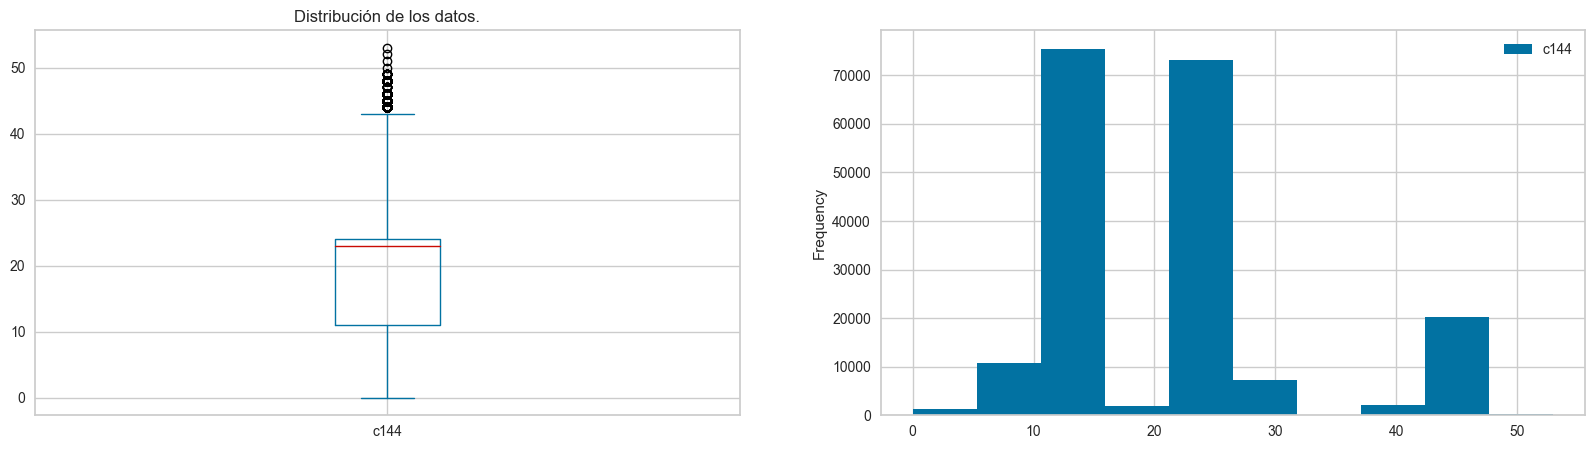

[+] VALUES_ENCODED	 ['1B0' '1B00' '1B71' '1B72' '1D71' '1E71' '1F71' '1G00' '1G71' '1G72'
 '1H00' '1H71' '1H72' '1H73' '1H74' '1H81' '1K0' '1K00' '1K01' '1K7'
 '1K71' '1K72' '1L00' '1L71' '1L72' '1L73' '1L74' '1M71' '1M72' '1P71'
 '1Q71' '1S71' '1W71' '1X71' '1X72' '2D71' '2D74' '2G71' '2G72' '2H71'
 '2H72' '2H73' '2H74' '2L71' '2L72' '2L73' '2L74' '2M71' '2M72' '2M74'
 '2Q72' '2Q73' '2S72' '2X74' nan]
[+] SKEW	 0.9694735893495751


,c144
count,189510
unique,46
top,1H71
freq,72438


In [21]:
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

No es necesario realizar imputaciones

##### <h6><div style="font-size:14px; text-align:left"><b>c145: Code for Weight  Class</b></div></h6>

In [22]:
col = 'c145'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isnull().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Code for Weight  Class 

[+] NAN_VALUES	0	0.0 %


,c145
count,189510
unique,2
top,1
freq,166918


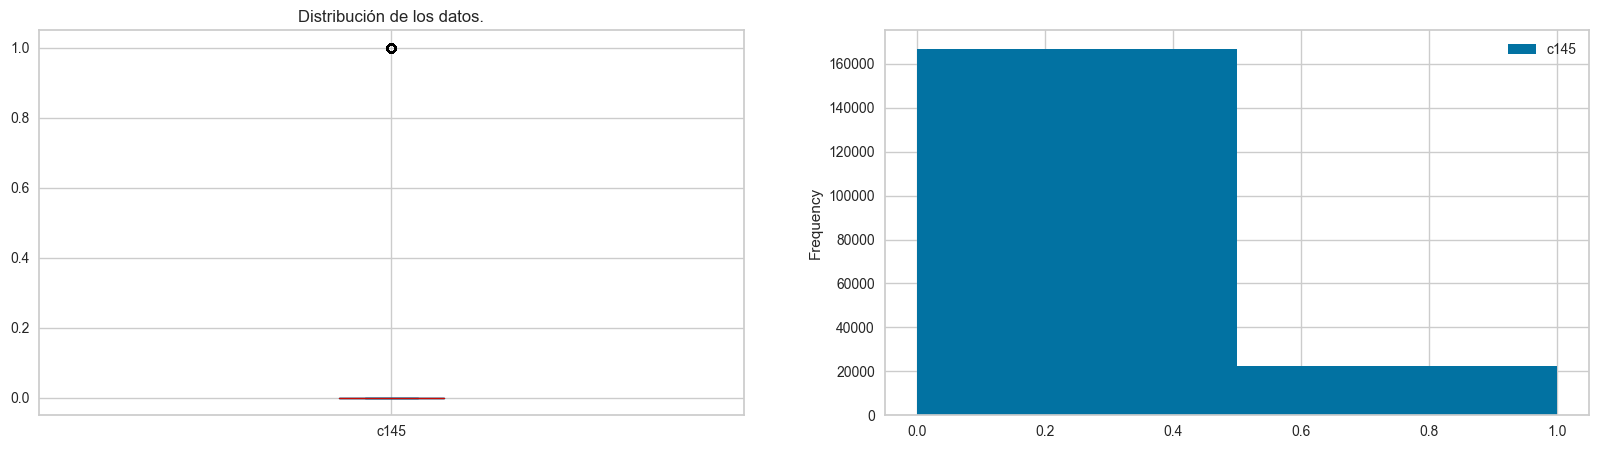

[+] VALUES_ENCODED	 ['1' '2']
[+] SKEW	 2.350277196930603


,c145
count,189510
unique,2
top,1
freq,166918


In [23]:
categorical_histogram(col, df, bins=2)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

No es necesario realizar imputaciones

##### <h6><div style="font-size:14px; text-align:left"><b>c147: Wing information of the aircraft involved in the investigation</b></div></h6>

In [24]:
df['c147'] = df['c147'].map(lambda x: x if x in ['B','D','G','H','K','L','M','Q','S'] else np.nan)

In [25]:
col = 'c147'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Wing information of the aircraft involved in the investigation. 

[+] NAN_VALUES	62	0.03 %


,c147
count,189448
unique,9
top,L
freq,93237


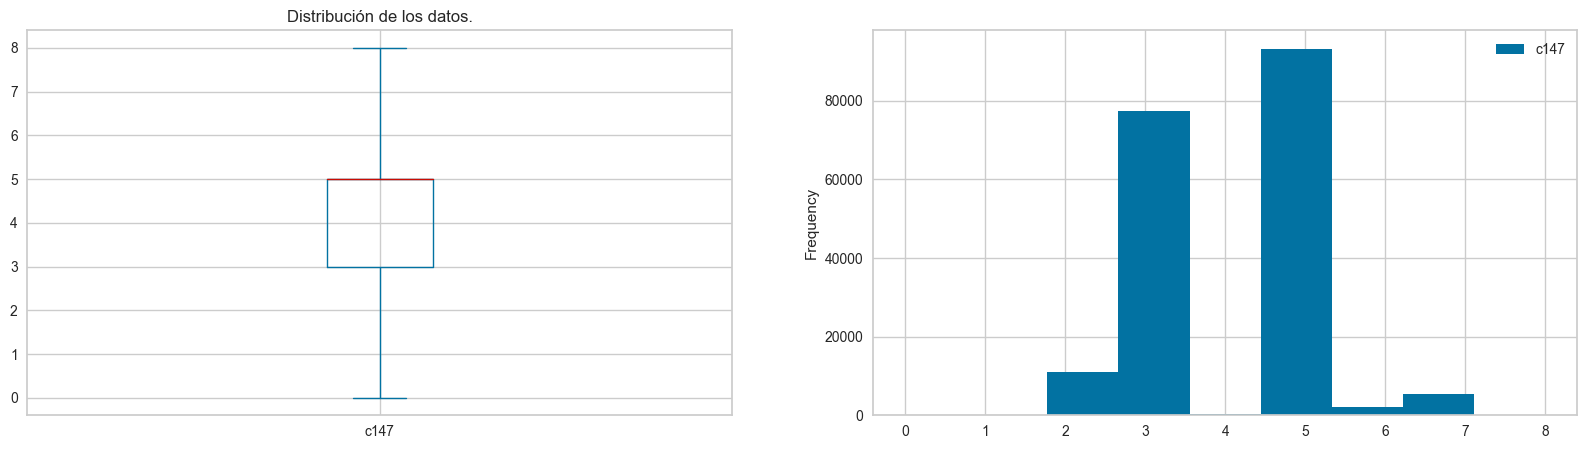

[+] VALUES_ENCODED	 ['B' 'D' 'G' 'H' 'K' 'L' 'M' 'Q' 'S' nan]
[+] SKEW	 0.08321590152539925


,c147
count,189448
unique,9
top,L
freq,93237


In [26]:
categorical_histogram(col, df, bins=9)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

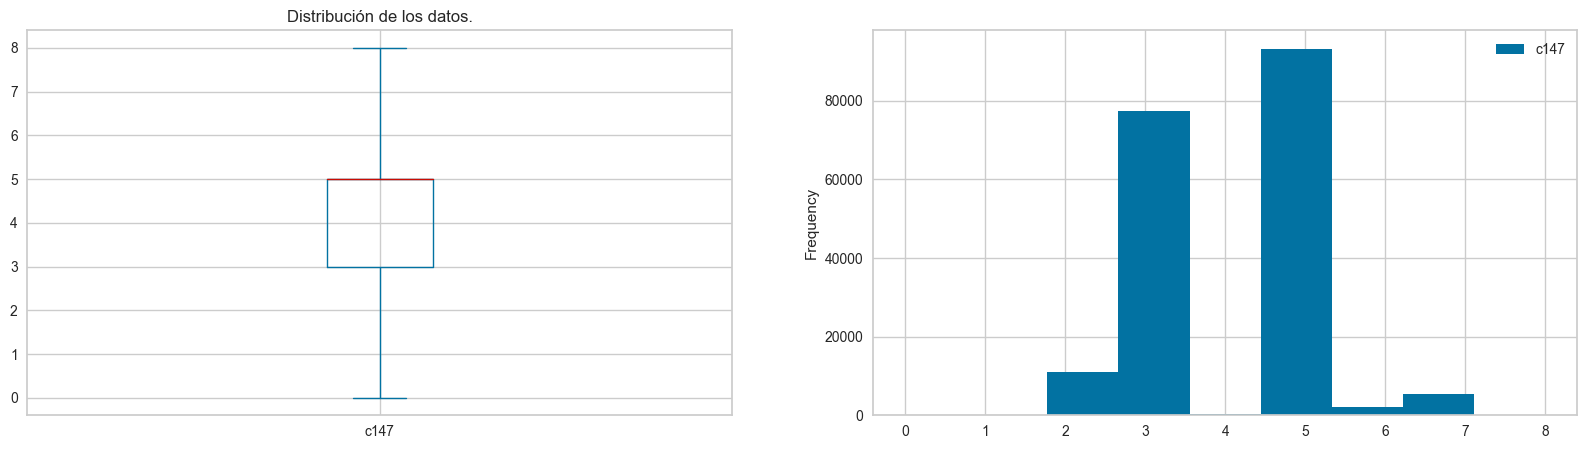

[+] VALUES_ENCODED	 ['B' 'D' 'G' 'H' 'K' 'L' 'M' 'Q' 'S']
[+] SKEW	 0.08259714823954237


,c147
count,189510
unique,9
top,L
freq,93299


In [27]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True)
categorical_histogram(col, df, bins=9)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c149: Powered, Nonpowered, Optional</b></div></h6>

In [28]:
col = 'c149'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Powered, Nonpowered, Optional 

[+] NAN_VALUES	0	0.0 %


,c149
count,189510
unique,3
top,7
freq,189508


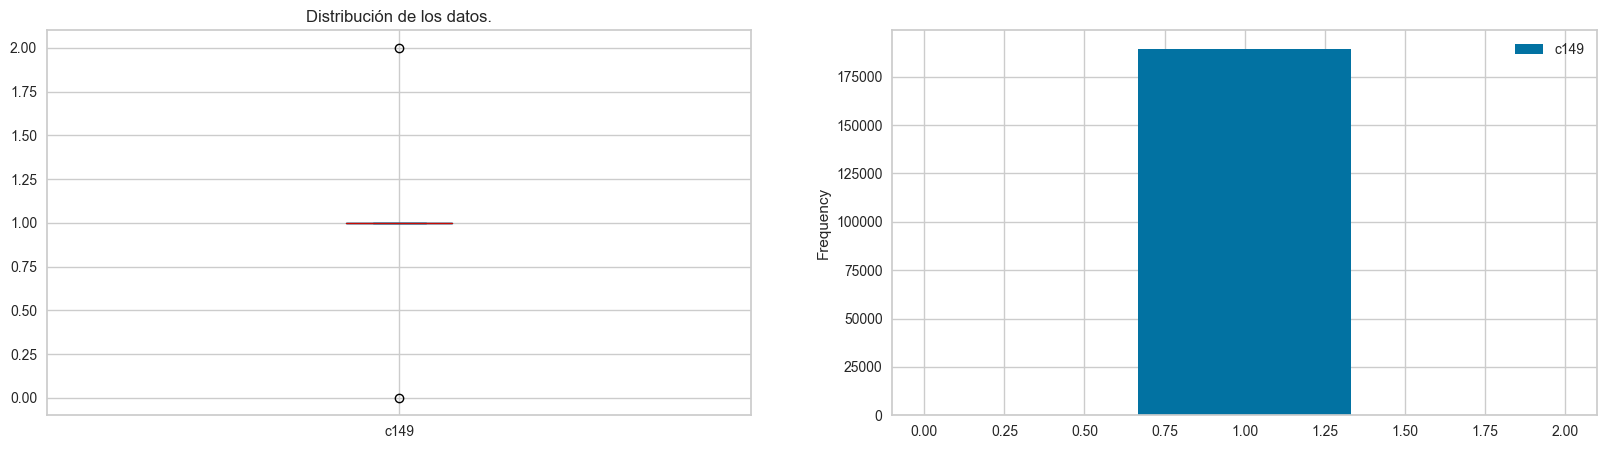

[+] VALUES_ENCODED	 ['0' '7' '8']
[+] SKEW	 0.0


,c149
count,189510
unique,3
top,7
freq,189508


In [29]:
categorical_histogram(col, df, bins=3)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

No es necesario realizar imputaciones

##### <h6><div style="font-size:14px; text-align:left"><b>c151: Number of engines on aircraft</b></div></h6>

In [30]:
col = 'c151'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Number of engines on aircraft 

[+] NAN_VALUES	0	0.0 %


,c151
count,189510.000000
mean,1.306348
std,0.568921
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


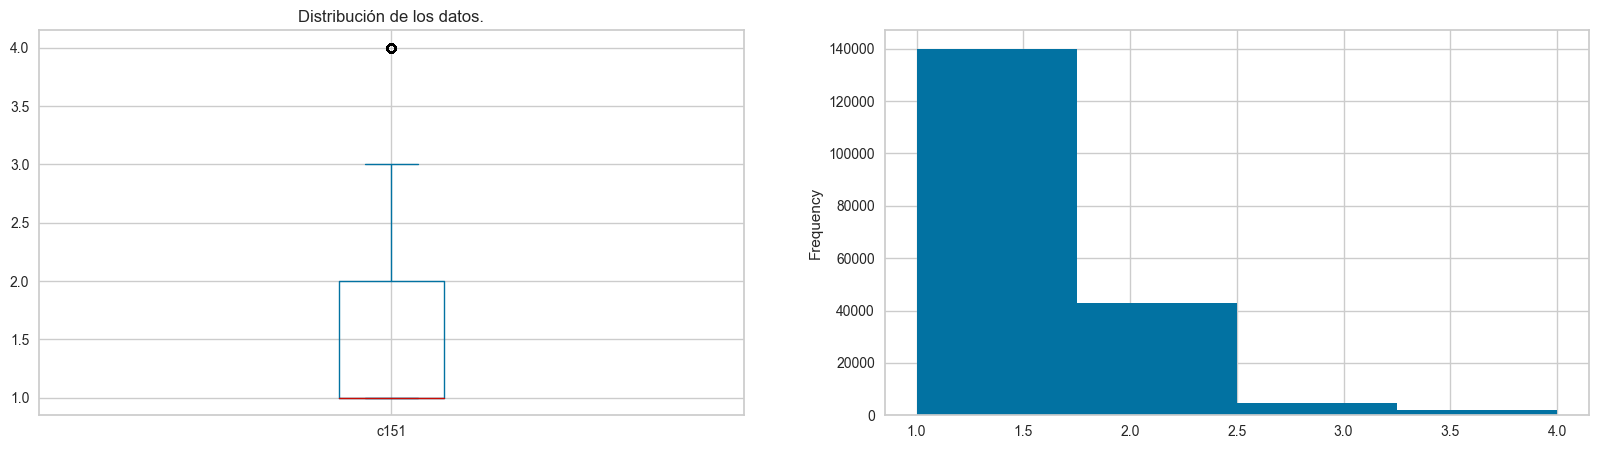

[+] SKEW	 2.0363234928624134


,c151
count,189510.000000
mean,1.306348
std,0.568921
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


In [31]:
numerical_histogram(col, df, bins=4)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

No es necesario realizar imputaciones

##### <h6><div style="font-size:14px; text-align:left"><b>c153: Under or over 750 hp</b></div></h6>

In [32]:
col = 'c153'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Under or over 750 hp. 

[+] NAN_VALUES	114006	60.16 %


,c153
count,75504
unique,2
top,3
freq,67367


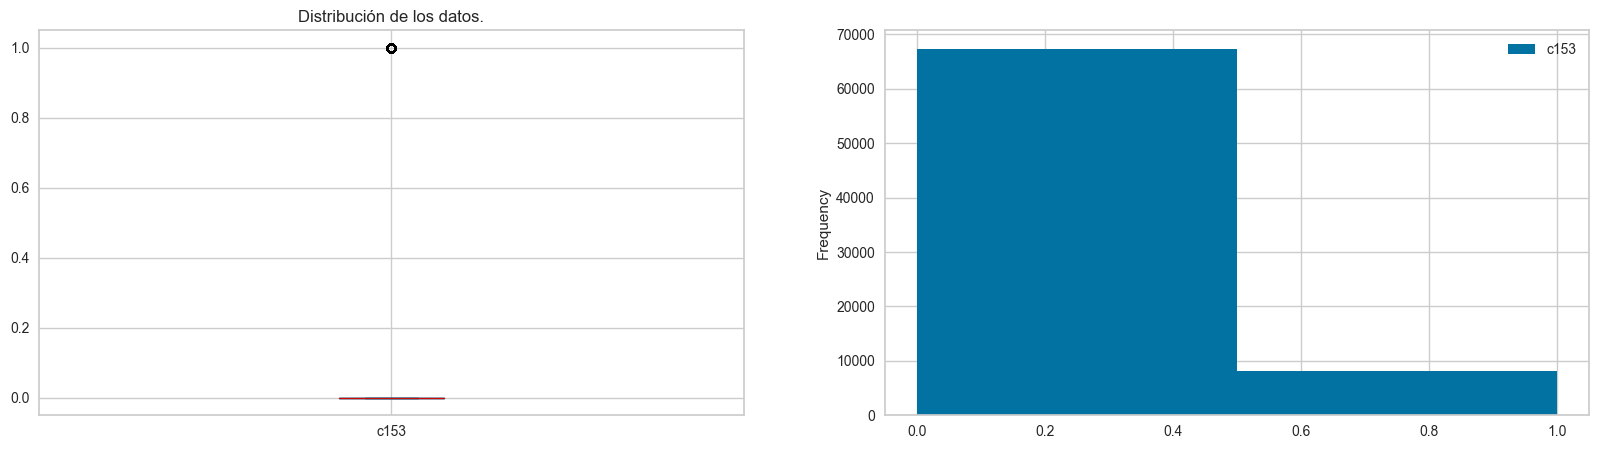

[+] VALUES_ENCODED	 ['3' '4' nan]
[+] SKEW	 2.529848992877319


,c153
count,75504
unique,2
top,3
freq,67367


In [33]:
categorical_histogram(col, df, bins=2)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [34]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	79713


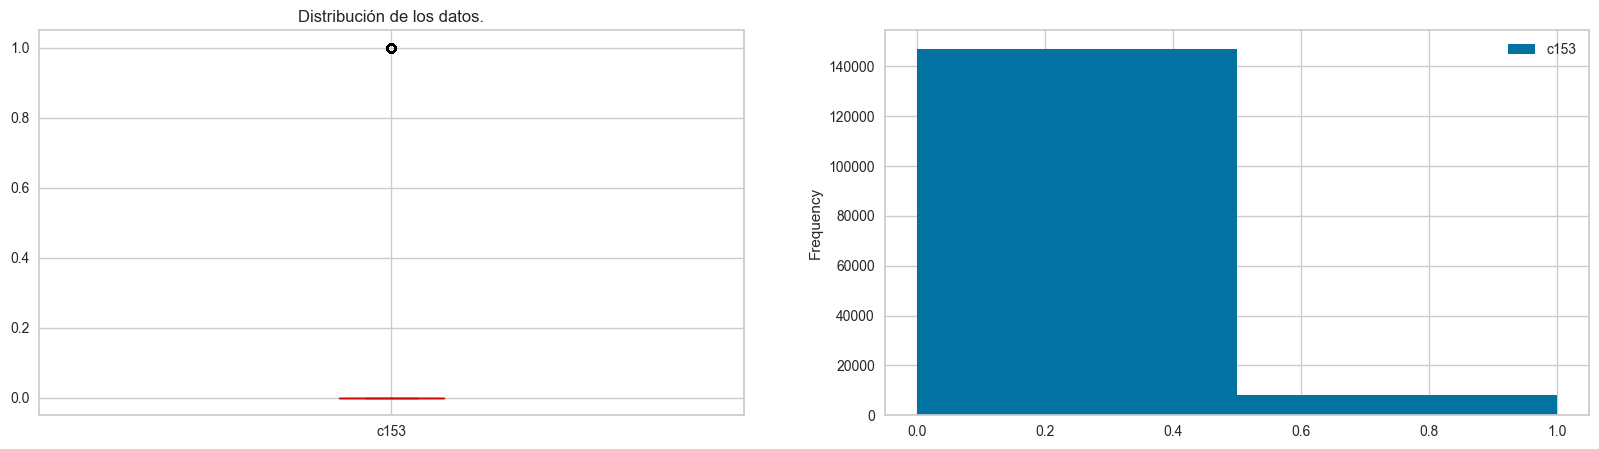

[+] VALUES_ENCODED	 ['3' '4' nan]
[+] SKEW	 4.016353221066267


,c153
count,155217
unique,2
top,3
freq,147080


In [35]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=2)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c155: Type of the engine code</b></div></h6>

In [36]:
df['c155'] = df['c155'].map(lambda x: np.nan if (x == '0') else x)
df['c155'] = df['c155'].map(lambda x: 'I' if (x == '1') else x)
df['c155'].unique()

array([nan, 'O', 'F', 'R', 'T', 'U', 'J', 'I', 'V', 'X', 'B', 'W'],
      dtype=object)

In [37]:
col = 'c155'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Type of the engine code. 

[+] NAN_VALUES	114007	60.16 %


,c155
count,75503
unique,11
top,O
freq,59195


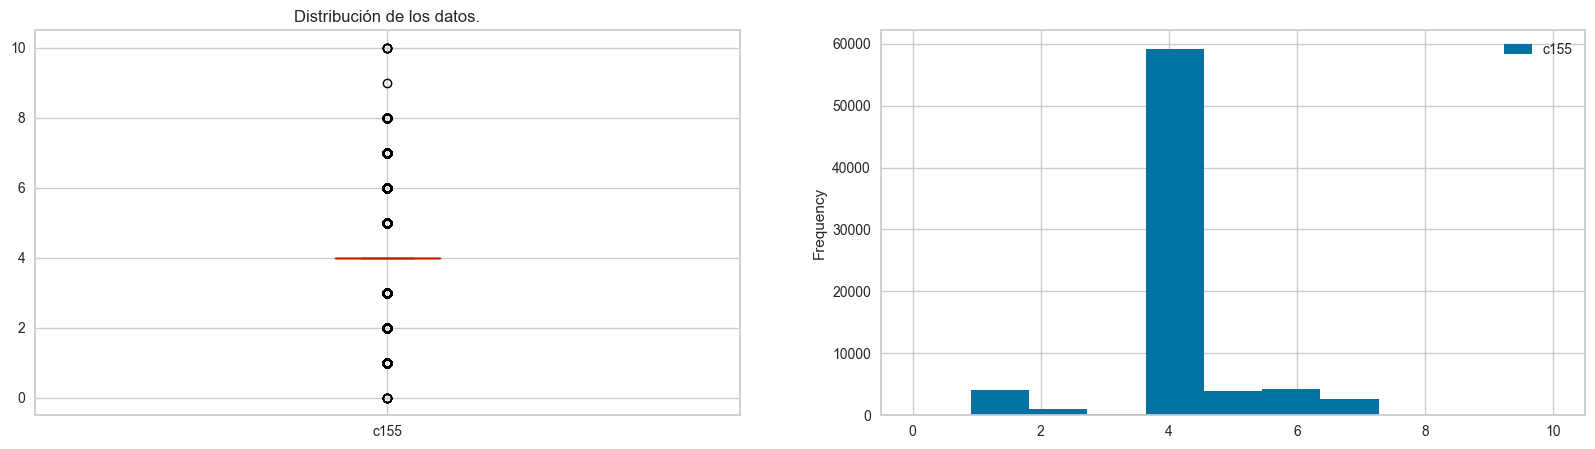

[+] VALUES_ENCODED	 ['B' 'F' 'I' 'J' 'O' 'R' 'T' 'U' 'V' 'W' 'X' nan]
[+] SKEW	 -0.27860836425289076


,c155
count,75503
unique,11
top,O
freq,59195


In [38]:
categorical_histogram(col, df, bins=11)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [39]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	79714


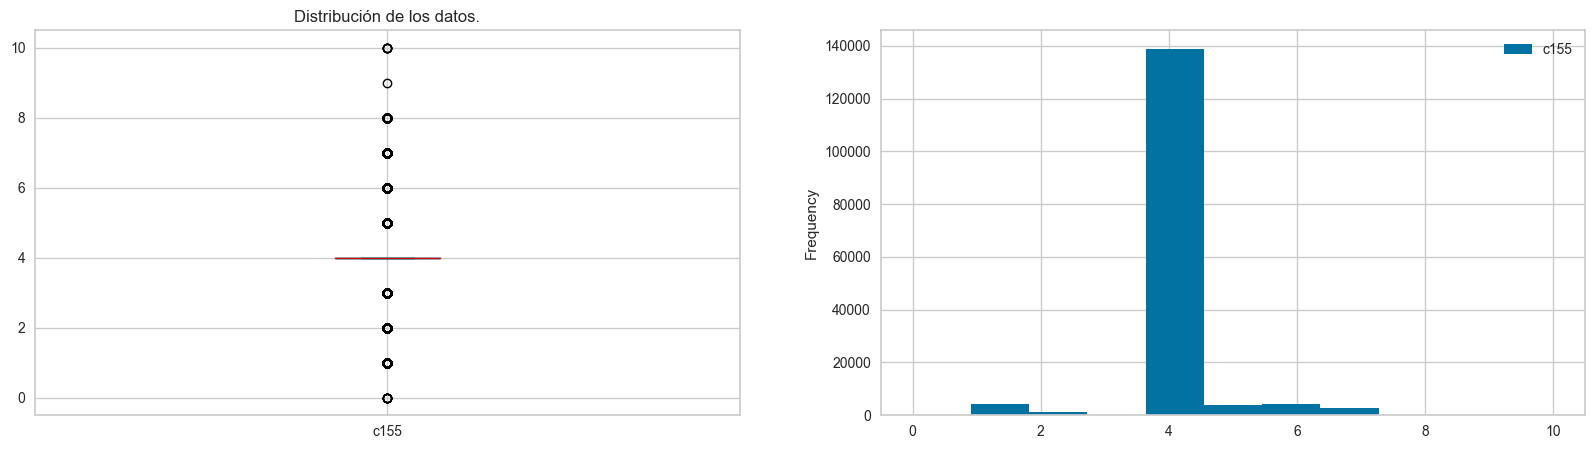

[+] VALUES_ENCODED	 ['B' 'F' 'I' 'J' 'O' 'R' 'T' 'U' 'V' 'W' 'X' nan]
[+] SKEW	 -0.24551861920041157


,c155
count,155217
unique,11
top,O
freq,138909


In [40]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=11)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c157: Type of Landing Gear code</b></div></h6>

In [41]:
df['c157'] = df['c157'].map(lambda x: np.nan if (x == '0') else x)
df['c157'] = df['c157'].map(lambda x: 'R' if (x == '0E') else x)
df['c157'] = df['c157'].map(lambda x: 'F' if (x == 'J') else x)

In [42]:
col = 'c157'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Type of Landing Gear code. 

[+] NAN_VALUES	126538	66.77 %


,c157
count,62972
unique,12
top,TR
freq,51881


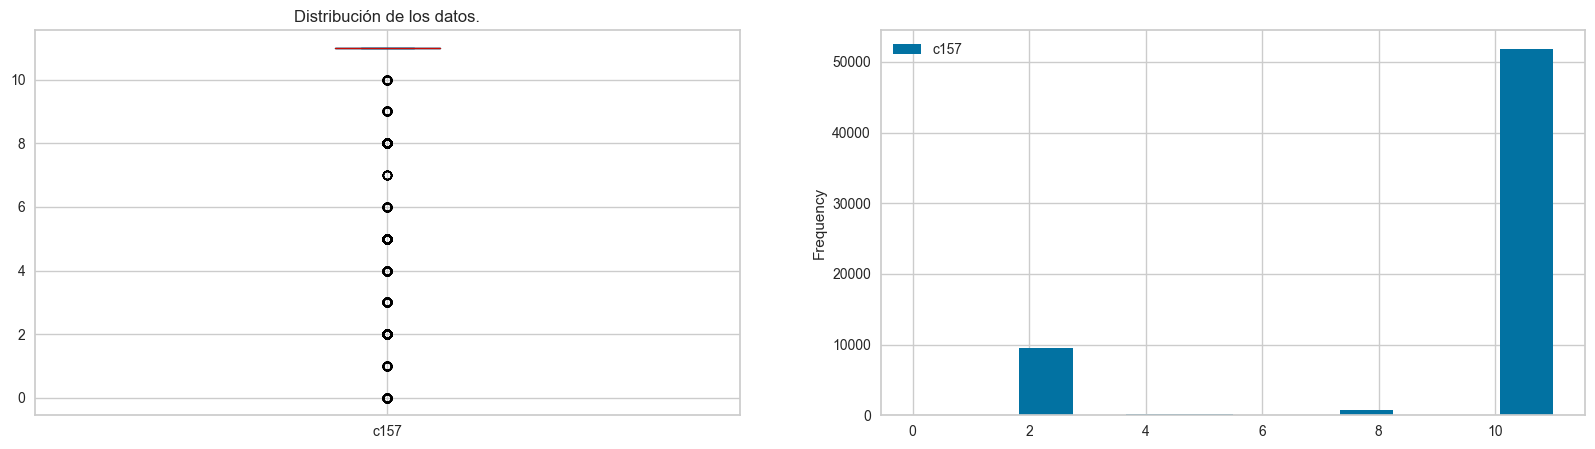

[+] VALUES_ENCODED	 ['AF' 'AH' 'CV' 'F' 'FL' 'O' 'OT' 'R' 'SD' 'SK' 'T' 'TR' nan]
[+] SKEW	 -1.8175811385065674


,c157
count,62972
unique,12
top,TR
freq,51881


In [43]:
categorical_histogram(col, df, bins=12)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [44]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	84293


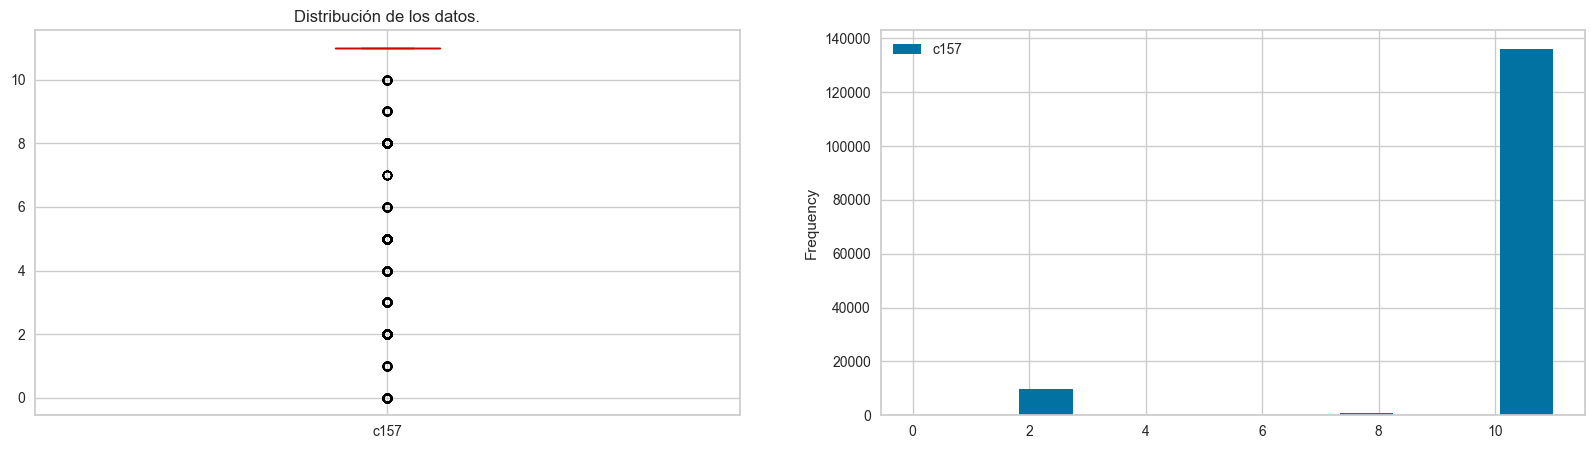

[+] VALUES_ENCODED	 ['AF' 'AH' 'CV' 'F' 'FL' 'O' 'OT' 'R' 'SD' 'SK' 'T' 'TR' nan]
[+] SKEW	 -3.3700862431676994


,c157
count,147265
unique,12
top,TR
freq,136174


In [45]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=12)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c30: Airworthiness class code of the aircraft</b></div></h6>

In [46]:
col = 'c30'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Airworthiness class code of the aircraft 

[+] NAN_VALUES	166487	87.85 %


,c30
count,23023
unique,6
top,STRD
freq,20765


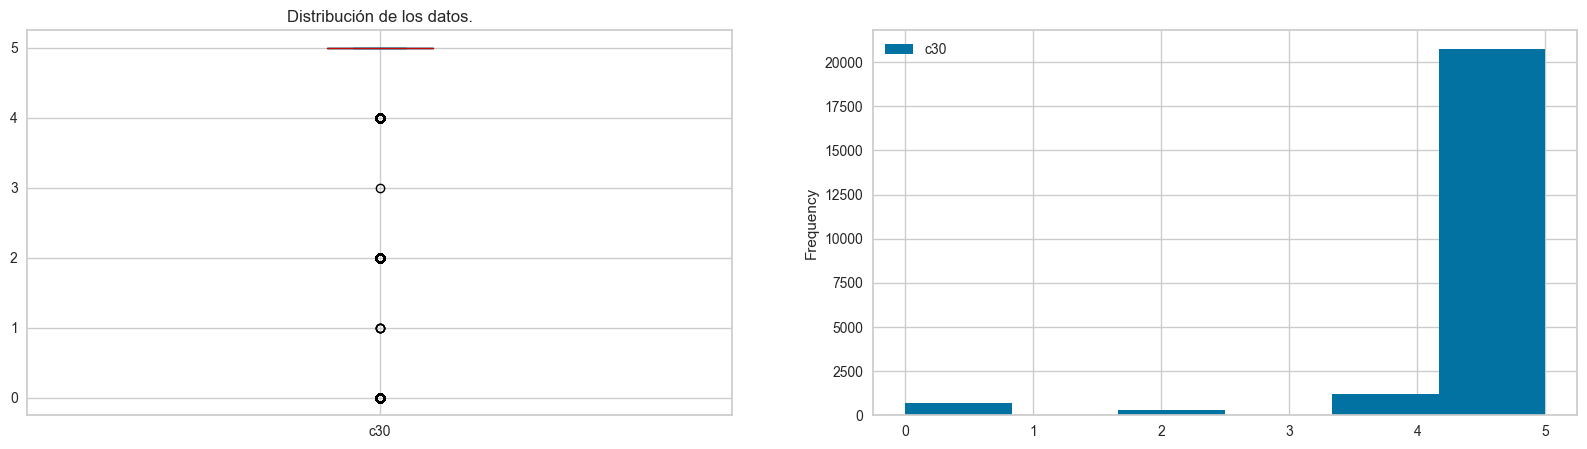

[+] VALUES_ENCODED	 ['EXPT' 'LIMT' 'MULT' 'PROV' 'REST' 'STRD' nan]
[+] SKEW	 -4.311755988543104


,c30
count,23023
unique,6
top,STRD
freq,20765


In [47]:
categorical_histogram(col, df, bins=6)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [48]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	93358


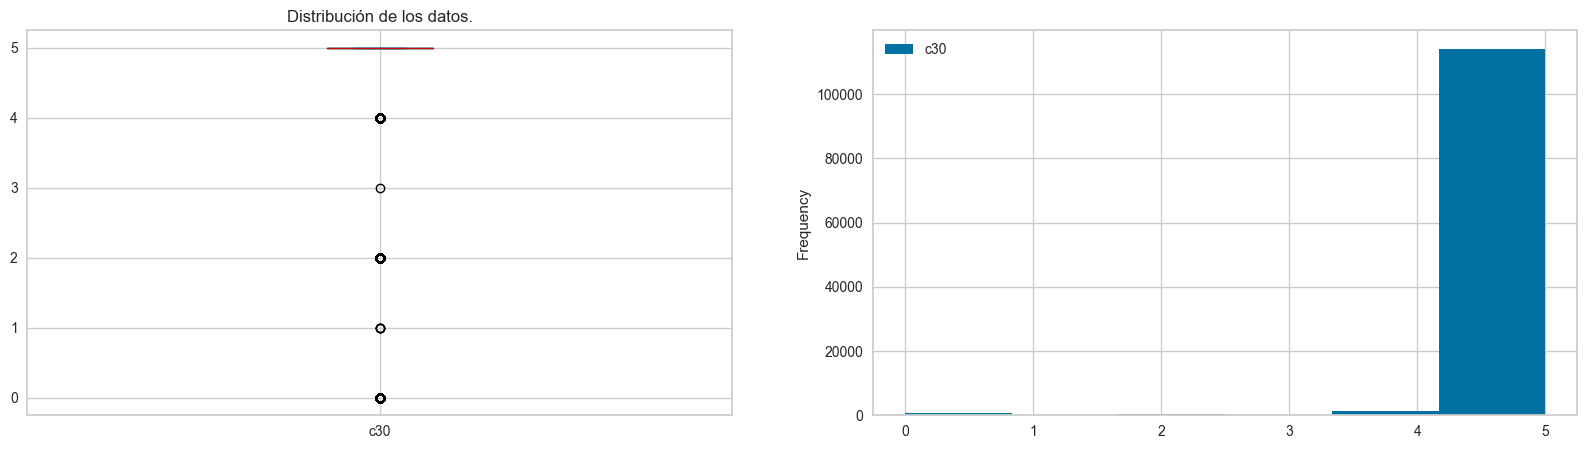

[+] VALUES_ENCODED	 ['EXPT' 'LIMT' 'MULT' 'PROV' 'REST' 'STRD' nan]
[+] SKEW	 -10.268825769335477


,c30
count,116381
unique,6
top,STRD
freq,114123


In [49]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=6)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

<h6><div style="font-size:14px; text-align:left"><b>c31 Airframe hours of the aircraft</b><br></div></h6>

In [50]:
# Convertir los valores NaN a -1
col = 'c31'
df[col].fillna(-1, inplace=True)

# Convertir el tipo de datos de la columna a entero, aquellos que den error, se 
# convierten a NaN
df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
df[col].info()

<class 'pandas.core.series.Series'>
Int64Index: 189510 entries, 0 to 214628
Series name: c31
Non-Null Count   Dtype
--------------   -----
189510 non-null  int32
dtypes: int32(1)
memory usage: 2.2 MB


In [51]:
col = 'c31'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Airframe hours of the aircraft 

[+] NAN_VALUES	0	0.0 %


,c31
count,189510.000000
mean,2748.467416
std,6846.465660
min,-1.000000
25%,-1.000000
50%,356.000000
75%,3125.000000
max,99999.000000


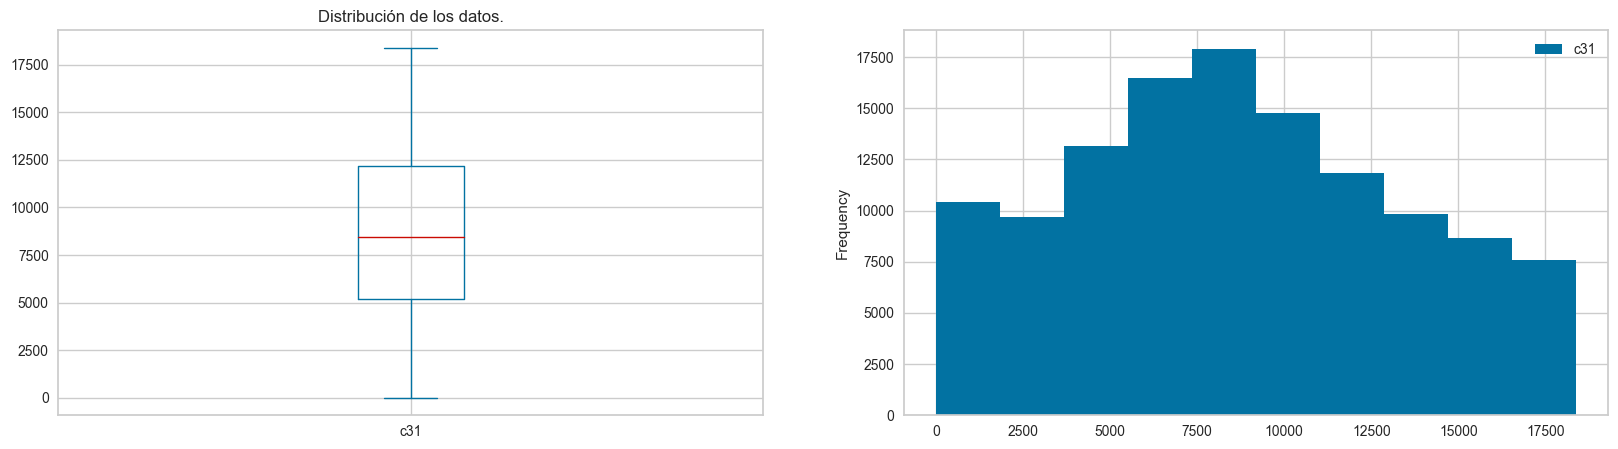

[+] VALUES_ENCODED	 ['0.0' '1.0' '10.0' ... '9999.0' '99999.0' nan]
[+] SKEW	 0.11947470419225156


,c31
count,189510.000000
mean,2748.467416
std,6846.465660
min,-1.000000
25%,-1.000000
50%,356.000000
75%,3125.000000
max,99999.000000


In [52]:
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Se imputa los datos faltantes con la media de los atributos.

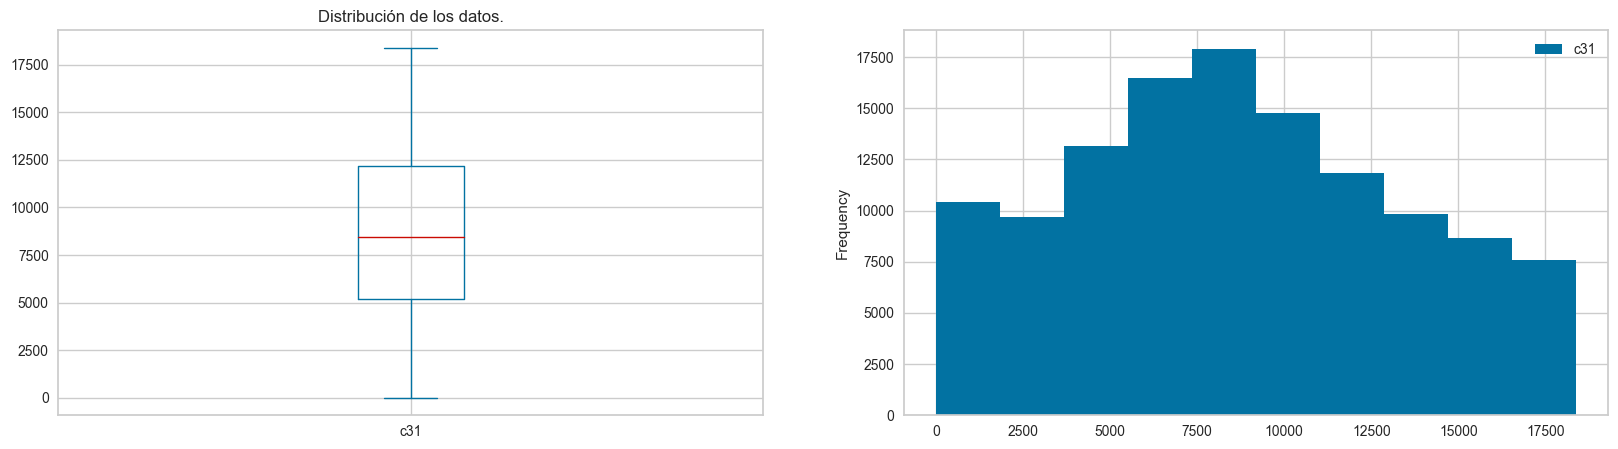

[+] VALUES_ENCODED	 ['0.0' '1.0' '10.0' ... '9999.0' '99999.0' nan]
[+] SKEW	 0.11947470419225156


,c31
count,189510.000000
mean,2748.467416
std,6846.465660
min,-1.000000
25%,-1.000000
50%,356.000000
75%,3125.000000
max,99999.000000


In [53]:
df[col].fillna(df[col].mean(), inplace=True)
categorical_histogram(col)
df[[col]].describe()

Se observa con la imputación de los valores que la desviación estandar se reduce así como la mediana y la moda coinciden. Más adelante se seguirá trabajando este atributo al tener un fuerte sesgo hacia la derecha.

In [54]:
# Escalono la horas de vuelo en tramos de 5000

import math

def horas_vuelo(h):
    try:
        h = int(float(h))
        return int(math.ceil(h/5000) * 5000)
    except:
        return np.NaN

df['c31'].replace(0, np.nan, inplace=True)
df['c31'] = df['c31'].map(lambda x: horas_vuelo(x))
df['c31']

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
           ...   
214616        0.0
214617    10000.0
214624    15000.0
214625    15000.0
214628     5000.0
Name: c31, Length: 189510, dtype: float64

##### <h6><div style="font-size:14px; text-align:left"><b>c33: Low wing, high wing, rotary wing, etc.</b></div></h6>

In [55]:
col = 'c33'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Low wing, high wing, rotary wing, etc. 

[+] NAN_VALUES	21432	11.31 %


,c33
count,168078
unique,13
top,L
freq,84020


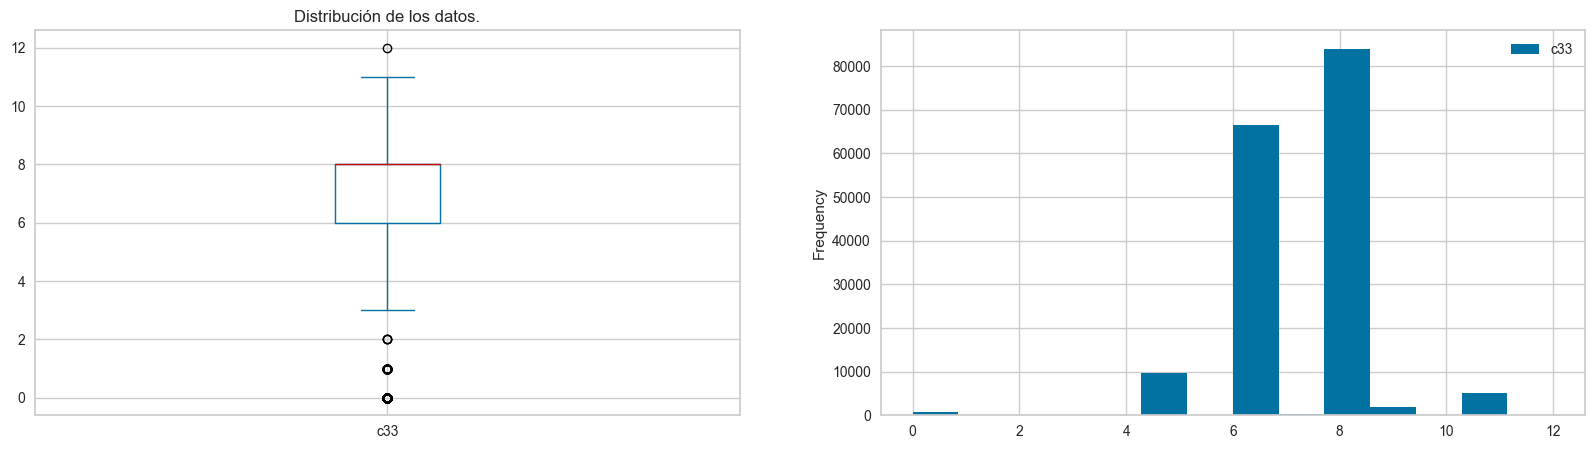

[+] VALUES_ENCODED	 ['1' '2' '7' 'B' 'D' 'G' 'H' 'K' 'L' 'M' 'O' 'Q' 'S' nan]
[+] SKEW	 -0.13282988514079344


,c33
count,168078
unique,13
top,L
freq,84020


In [56]:
categorical_histogram(col, df, bins=14)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

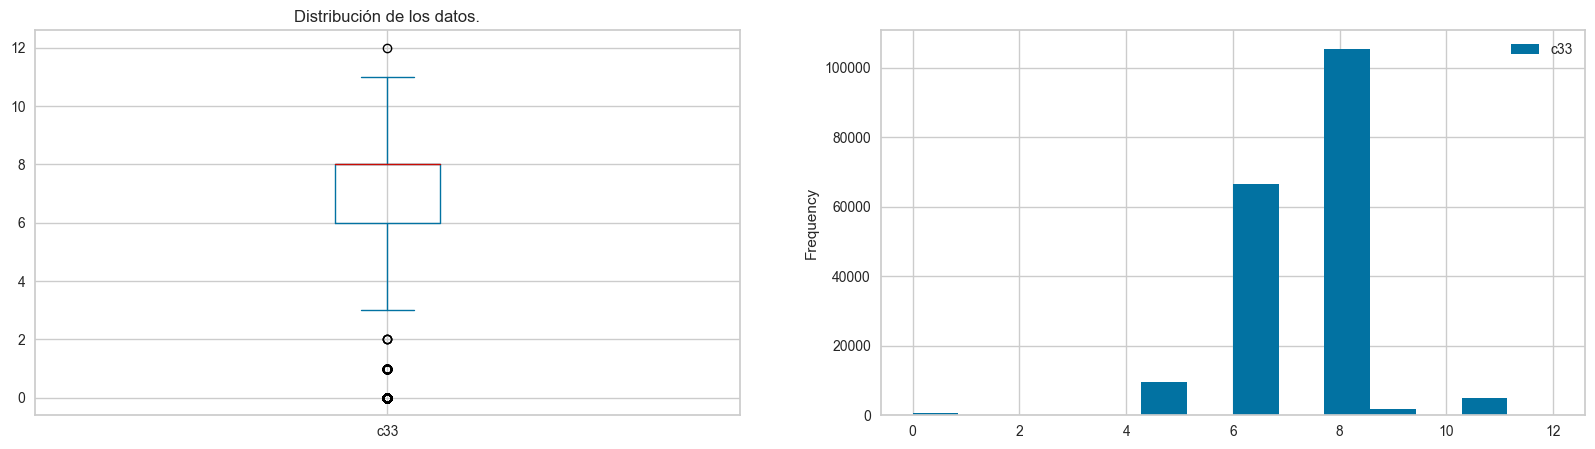

[+] VALUES_ENCODED	 ['1' '2' '7' 'B' 'D' 'G' 'H' 'K' 'L' 'M' 'O' 'Q' 'S']
[+] SKEW	 -0.3276960302708106


,c33
count,189510
unique,13
top,L
freq,105452


In [57]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True)
categorical_histogram(col, df, bins=14)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c34: Make of the engine</b></div></h6>

In [58]:
col = 'c34'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Make of the engine 

[+] NAN_VALUES	100228	52.89 %


,c34
count,89282
unique,169
top,LYC
freq,33115


In [59]:
# Tratamiento para la columna c34 Make of the engine
# Puesto que tiene muchos valores y a simple vista hay valores coincidentes se realiza tratamiento para unificar

for x,y in enumerate(df['c34']):
    if y in ['AERO','AERO S','AERO V','AERO-S','AEROCO','AEROMA','AEROMO','AEROSP','AEROTE','AEROVE',]:
        df.loc[x,'c34'] = 'AERO'
    elif y in ['ALIDSG','ALISPO','ALLIED','ALLISI','ALLISO','ALLSN']:
        df.loc[x,'c34'] = 'AERO'
    elif y in ['AMTR','AMTRBU','AMTRCA','AMTRFR','AMTRGM','AMTRHD','AMTRKK','AMTRLC','AMTRMC','AMTROL','AMTRRM','AMTRRW',
               'AMTRVW','AMTRWD']:
        df.loc[x,'c34'] = 'AMT'
    elif y in ['AVCO L','AVCO-L']:
        df.loc[x,'c34'] = 'AVCO L'
    elif y in ['BMW','BMW RO','BMW-V1']:
        df.loc[x,'c34'] = 'BMW'
    elif y in ['BOMBAR','BONBAR']:
        df.loc[x,'c34'] = 'BOMBAR'
    elif y in ['CHEVER','CHEVRO','CHEVY']:
        df.loc[x,'c34'] = 'CHEVY'
    elif y in ['CONT','CONT M','CONTEN','CONTI','CONTIE','CONTIN']:
        df.loc[x,'c34'] = 'CONT'
    elif y in ['DE HAV','DEHAV','DHAV','DHAVXX']:
        df.loc[x,'c34'] = 'DHAV'
    elif y in ['FRANKL','FRKLIN','FRNKLN']:
        df.loc[x,'c34'] = 'FRANKL'
    elif y in ['GARRET','GARRTT']:
        df.loc[x,'c34'] = 'GARRET'
    elif y in ['GE','GE AV','GE AVI','GE HON','GENELC','GENERA']:
        df.loc[x,'c34'] = 'GE'
    elif y in ['HONDA','HONDA,']:
        df.loc[x,'c34'] = 'HONDA'
    elif y in ['HOSAI','HOUSAI']:
        df.loc[x,'c34'] = 'HOUSAI'
    elif y in ['IAE','IAE V2','IAME']:
        df.loc[x,'c34'] = 'IAE'
    elif y in ['JABIRU','JABIUR']:
        df.loc[x,'c34'] = 'JABIRU'
    elif y in ['KEN RO','KENROY']:
        df.loc[x,'c34'] = 'KENROY'
    elif y in ['LIMBAC','LIMBAH']:
        df.loc[x,'c34'] = 'LIMBA'
    elif y in ['LY-CON','LYC','LYCOM','LYCOMI','LYCOMM','LYCON','LYCONI','LZ DES']:
        df.loc[x,'c34'] = 'LY-CON'
    elif y in ['MCCULH','MCCULL']:
        df.loc[x,'c34'] = 'MCCULL'
    elif y in ['MOTORL','MOTORS']:
        df.loc[x,'c34'] = 'MOTOR'
    elif y in ['NA','NONE','UNK','UNKNOW']:
        df.loc[x,'c34'] = np.NaN
    elif y in ['O-360','O-360-']:
        df.loc[x,'c34'] = 'O-360'
    elif y in ['P & W','P W','P&W','P&W CA']:
        df.loc[x,'c34'] = 'P&W'
    elif y in ['PBS','PBS VE']:
        df.loc[x,'c34'] = 'PBS'
    elif y in ['PRATT','PRATT&','PRATT/','PT-6','PT6']:
        df.loc[x,'c34'] = 'PRATT'
    elif y in ['PZL-3S','PZL-MI','PZL-WS','PZLWSK']:
        df.loc[x,'c34'] = 'PZL'
    elif y in ['ROLLS','ROLLS-','ROOLS-','RR','RROYCE']:
        df.loc[x,'c34'] = 'RROYCE'
    elif y in ['ROTAC','ROTAX','ROTEC','ROTOAX','ROTORW','ROTOWA']:
        df.loc[x,'c34'] = 'ROTAX'
    elif y in ['SZEKEL','SZEKLY']:
        df.loc[x,'c34'] = 'SZEKE'
    elif y in ['TELEDY','TELMAT','TEMECA','TEXTRO']:
        df.loc[x,'c34'] = 'TELEDY'
    elif y in ['THIELE','THIELT']:
        df.loc[x,'c34'] = 'THIEL'
    elif y in ['TURBIN','TURBO','TURBOM']:
        df.loc[x,'c34'] = 'TURBO'
    elif y in ['VEDENE','VEDENY','VENDEN','VERNER']:
        df.loc[x,'c34'] = 'VEDEN'
    elif y in ['VOLKS','VOLKSW','VW']:
        df.loc[x,'c34'] = 'VW'
    else:
        pass

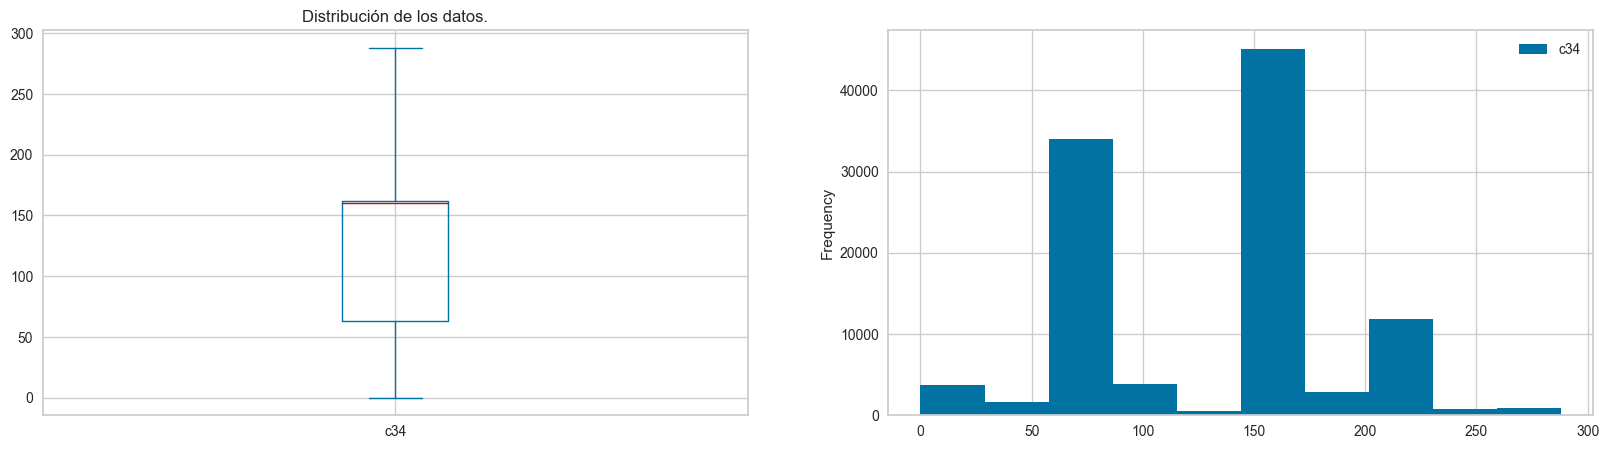

[+] VALUES_ENCODED	 ['912S' 'AERO' 'AERO S' 'AERO V' 'AERO-S' 'AEROCO' 'AEROMA' 'AEROMO'
 'AEROSP' 'AEROTE' 'AEROVE' 'AIR RE' 'AIRESE' 'ALIDSG' 'ALISPO' 'ALLIED'
 'ALLISI' 'ALLISO' 'ALLSN' 'ALVIS' 'AMA' 'AMA/EX' 'AMES' 'AMTR' 'AMTRBU'
 'AMTRCA' 'AMTRFR' 'AMTRGM' 'AMTRHD' 'AMTRKK' 'AMTRLC' 'AMTRMC' 'AMTROL'
 'AMTRRM' 'AMTRRW' 'AMTRVW' 'AMTRWD' 'ARONCA' 'ARSRCH' 'ASPTPW' 'AUDI'
 'AUSTRO' 'AUTOMO' 'AVCO L' 'AVCO-L' 'BARRET' 'BERGER' 'BMW' 'BMW RO'
 'BMW-V1' 'BOEING' 'BOMBAR' 'BONBAR' 'BRISTO' 'C F E' 'CFE' 'CFE CO'
 'CFM IN' 'CFMINT' 'CHEVER' 'CHEVRO' 'CHEVY' 'COMPAC' 'CONT' 'CONT M'
 'CONTEN' 'CONTI' 'CONTIE' 'CONTIN' 'CORVAI' 'CROSSF' 'CUBCRA' 'CURTIS'
 'DE HAV' 'DEHAV' 'DHAV' 'DHAVXX' 'DIAMON' 'DIEMEC' 'DIMECH' 'DJI' 'DLE'
 'EAGLE' 'EC-135' 'ECI' 'ECI TI' 'ECITIT' 'EGGEN' 'EGGENF' 'ENMA' 'EXP/ J'
 'EXPERI' 'EXPR' 'FAIRCH' 'FALCON' 'FCD' 'FORD' 'FORD M' 'FRANKL' 'FRKLIN'
 'FRNKLN' 'GARRET' 'GARRTT' 'GE' 'GE AV' 'GE AVI' 'GE HON' 'GENELC'
 'GENERA' 'GEO' 'GLADEN' 'GLOBAL' 'GM' 'GMC' 'GNO

,c34
count,128178
unique,155
top,CONT
freq,44854


In [60]:
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [61]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	73723


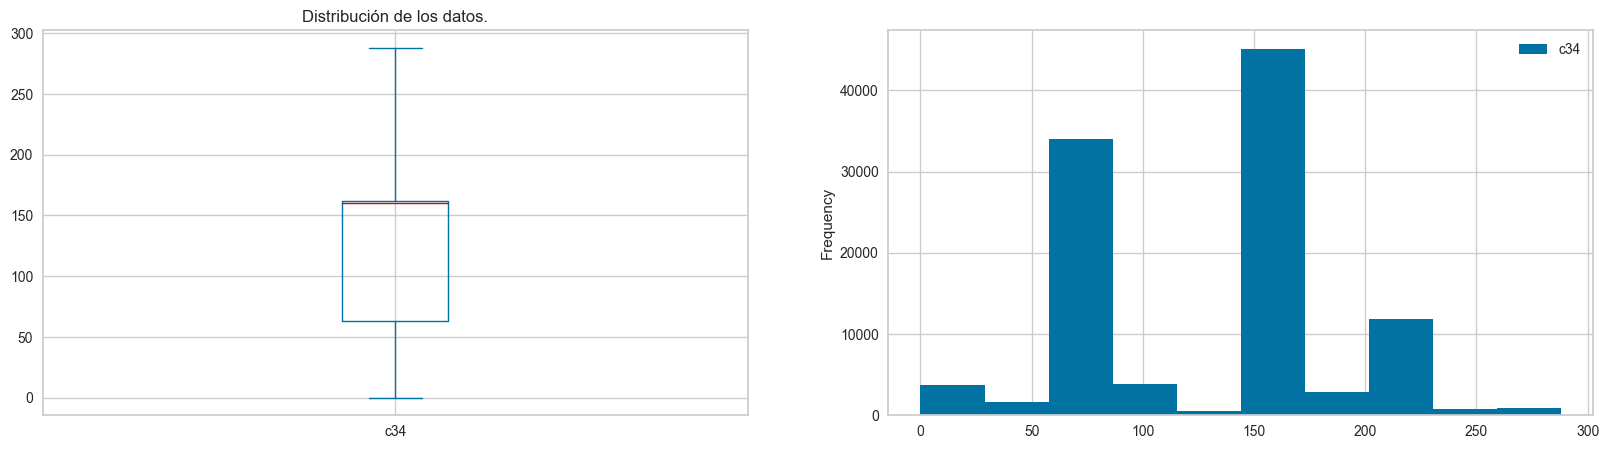

[+] VALUES_ENCODED	 ['912S' 'AERO' 'AERO S' 'AERO V' 'AERO-S' 'AEROCO' 'AEROMA' 'AEROMO'
 'AEROSP' 'AEROTE' 'AEROVE' 'AIR RE' 'AIRESE' 'ALIDSG' 'ALISPO' 'ALLIED'
 'ALLISI' 'ALLISO' 'ALLSN' 'ALVIS' 'AMA' 'AMA/EX' 'AMES' 'AMTR' 'AMTRBU'
 'AMTRCA' 'AMTRFR' 'AMTRGM' 'AMTRHD' 'AMTRKK' 'AMTRLC' 'AMTRMC' 'AMTROL'
 'AMTRRM' 'AMTRRW' 'AMTRVW' 'AMTRWD' 'ARONCA' 'ARSRCH' 'ASPTPW' 'AUDI'
 'AUSTRO' 'AUTOMO' 'AVCO L' 'AVCO-L' 'BARRET' 'BERGER' 'BMW' 'BMW RO'
 'BMW-V1' 'BOEING' 'BOMBAR' 'BONBAR' 'BRISTO' 'C F E' 'CFE' 'CFE CO'
 'CFM IN' 'CFMINT' 'CHEVER' 'CHEVRO' 'CHEVY' 'COMPAC' 'CONT' 'CONT M'
 'CONTEN' 'CONTI' 'CONTIE' 'CONTIN' 'CORVAI' 'CROSSF' 'CUBCRA' 'CURTIS'
 'DE HAV' 'DEHAV' 'DHAV' 'DHAVXX' 'DIAMON' 'DIEMEC' 'DIMECH' 'DJI' 'DLE'
 'EAGLE' 'EC-135' 'ECI' 'ECI TI' 'ECITIT' 'EGGEN' 'EGGENF' 'ENMA' 'EXP/ J'
 'EXPERI' 'EXPR' 'FAIRCH' 'FALCON' 'FCD' 'FORD' 'FORD M' 'FRANKL' 'FRKLIN'
 'FRNKLN' 'GARRET' 'GARRTT' 'GE' 'GE AV' 'GE AVI' 'GE HON' 'GENELC'
 'GENERA' 'GEO' 'GLADEN' 'GLOBAL' 'GM' 'GMC' 'GNO

,c34
count,195252
unique,155
top,CONT
freq,111928


In [62]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c35: Model of the engine</b></div></h6>

In [63]:
col = 'c35'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Model of the engine 

[+] NAN_VALUES	106807	54.7 %


,c35
count,88445
unique,2742
top,O200A
freq,3565


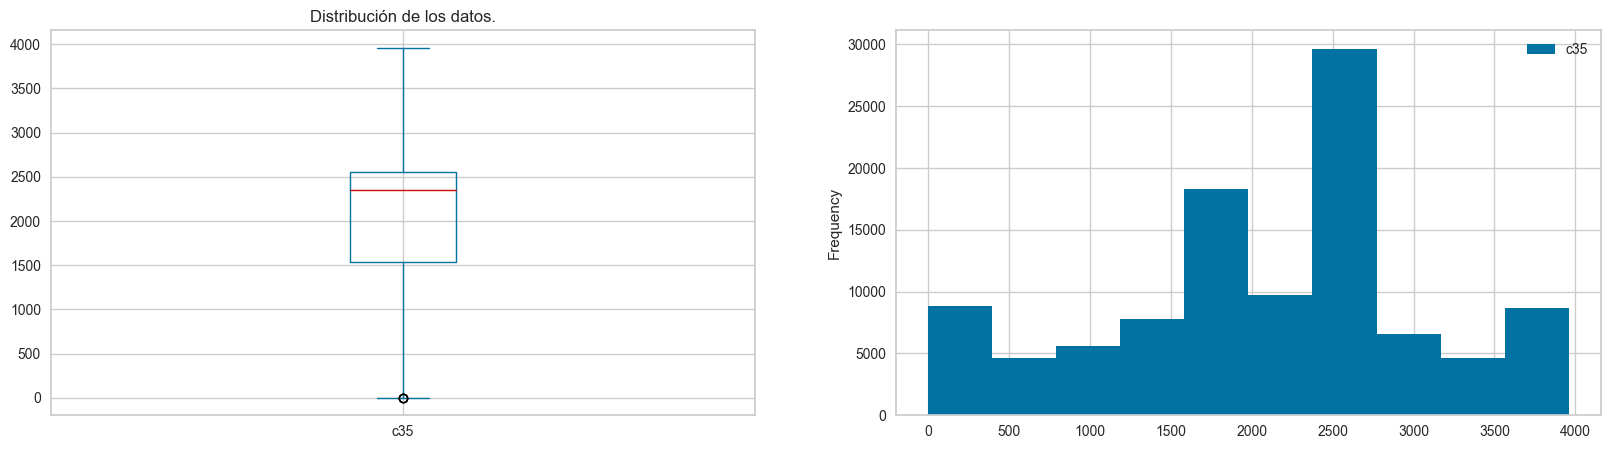

[+] VALUES_ENCODED	 ['(L) O-360-A1H' '0' '0 470-R' ... 'ZANZOTTERA' 'ZENOAH G-50' nan]
[+] SKEW	 -0.32499439437841354


,c35
count,88445
unique,2742
top,O200A
freq,3565


In [64]:
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [65]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	77595


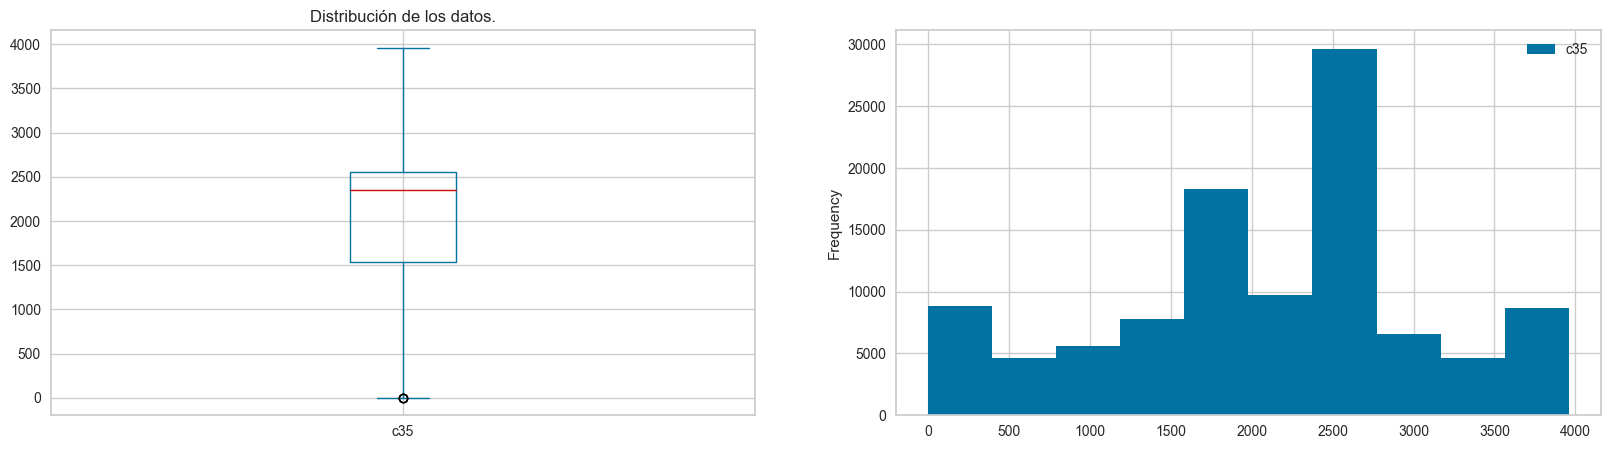

[+] VALUES_ENCODED	 ['(L) O-360-A1H' '0' '0 470-R' ... 'ZANZOTTERA' 'ZENOAH G-50' nan]
[+] SKEW	 -0.32499439437841354


,c35
count,166040
unique,2742
top,O200A
freq,81160


In [66]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c36: Group of the engine</b></div></h6>

In [67]:
col = 'c36'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Group of the engine 

[+] NAN_VALUES	117330	60.09 %


,c36
count,77922
unique,1248
top,O360
freq,10492


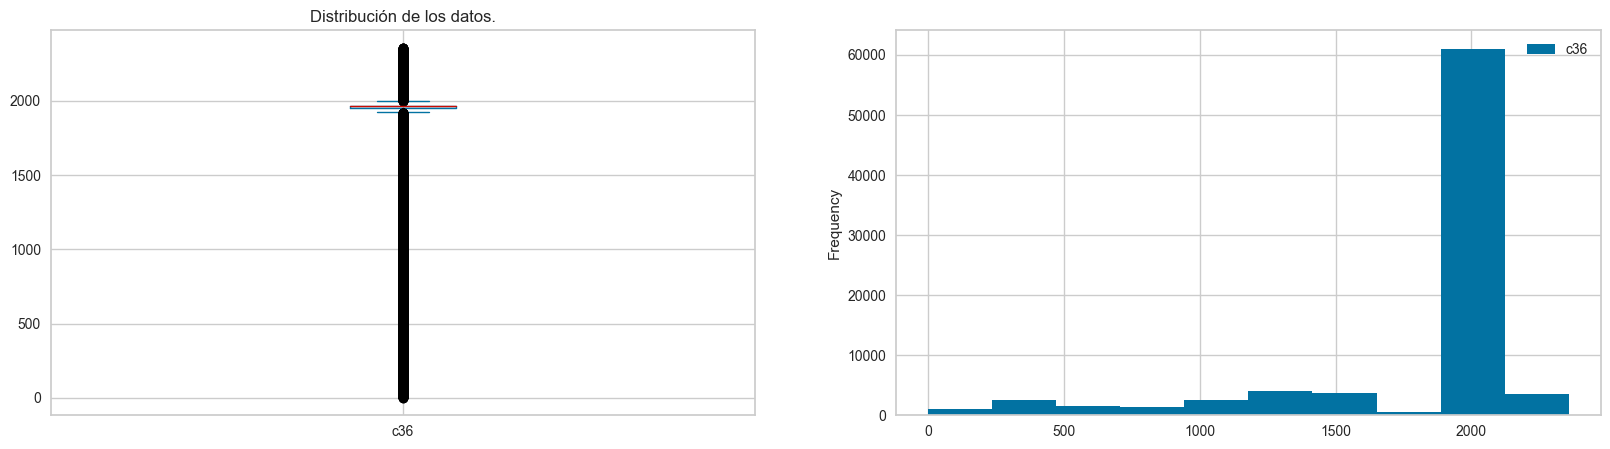

[+] VALUES_ENCODED	 ['#67803' '(11)' '-' ... 'ZP-101' 'ZP1042' nan]
[+] SKEW	 -2.1086293801614264


,c36
count,77922
unique,1248
top,O360
freq,10492


In [68]:
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [69]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	82078


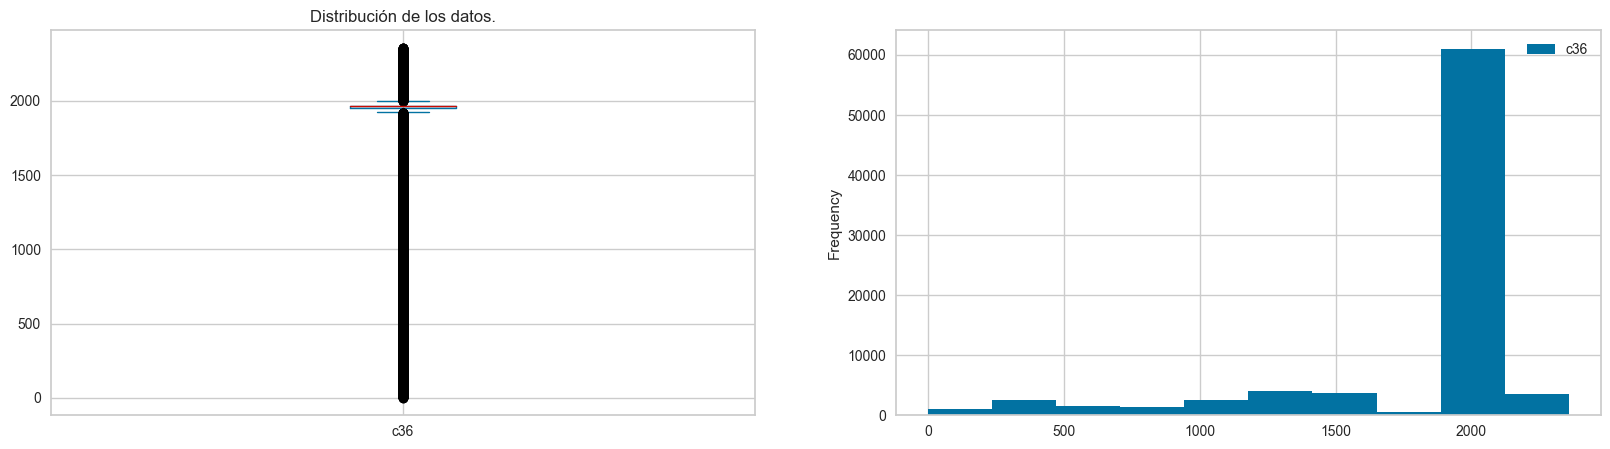

[+] VALUES_ENCODED	 ['#67803' '(11)' '-' ... 'ZP-101' 'ZP1042' nan]
[+] SKEW	 -2.1086293801614264


,c36
count,160000
unique,1248
top,O360
freq,92570


In [70]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c38: Certificating region of the engine</b></div></h6>

In [71]:
col = 'c38'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Certificating region of the engine 

[+] NAN_VALUES	119742	61.33 %


,c38
count,75510
unique,9
top,EA
freq,34584


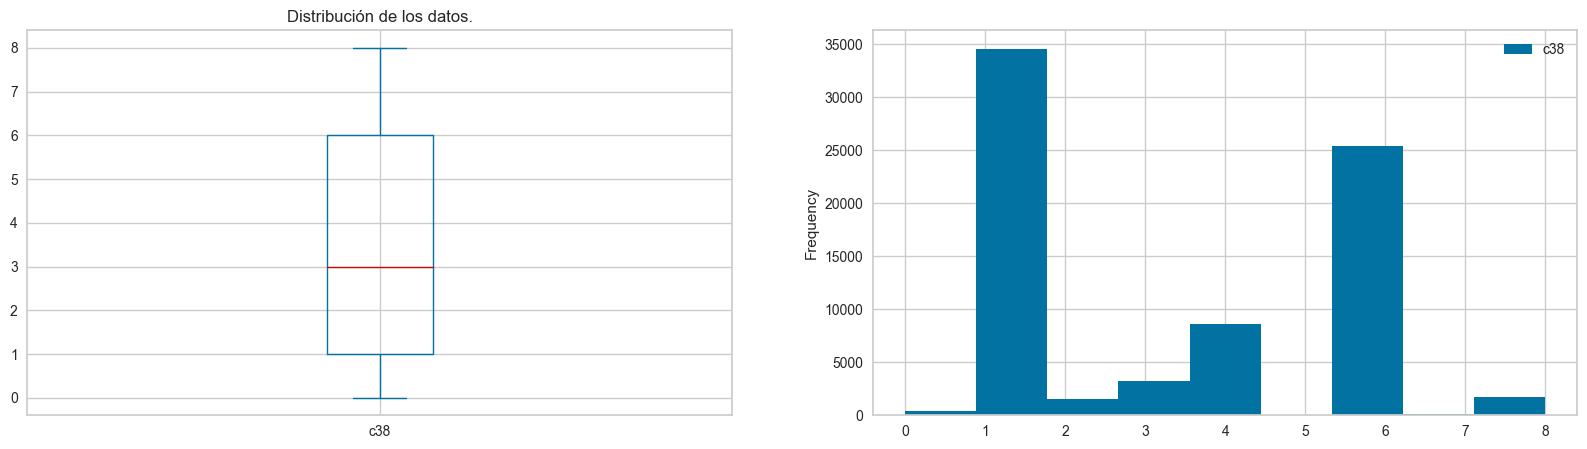

[+] VALUES_ENCODED	 ['CE' 'EA' 'EU' 'GL' 'NE' 'NM' 'SO' 'SW' 'WP' nan]
[+] SKEW	 0.26297214056277535


,c38
count,75510
unique,9
top,EA
freq,34584


In [72]:
categorical_histogram(col, df, bins=9)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [73]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	83023


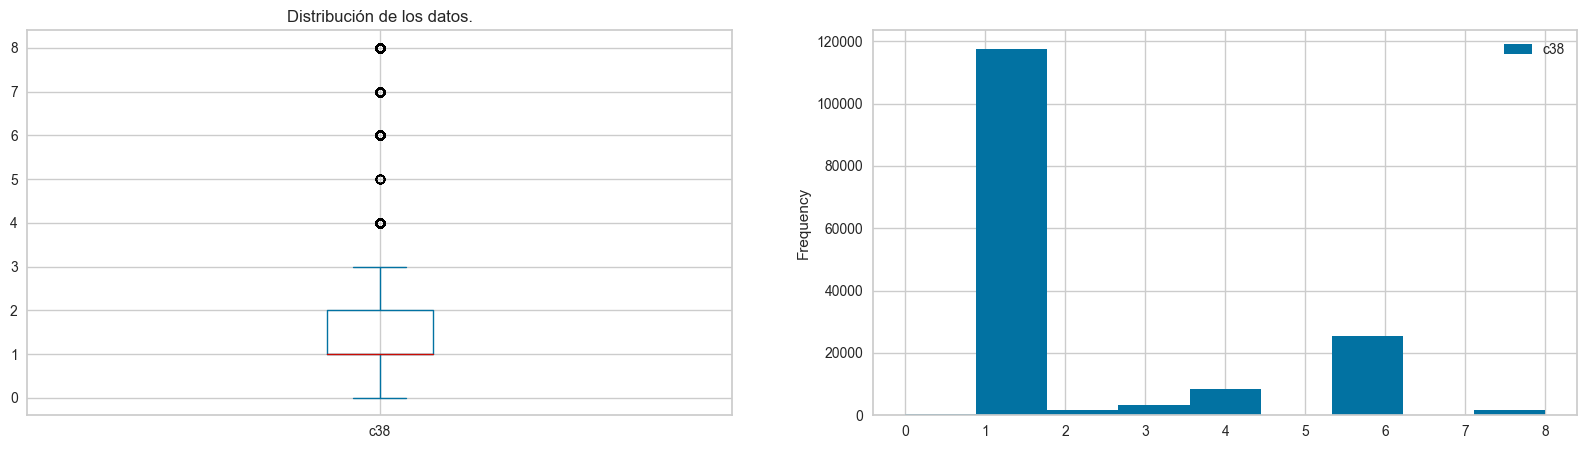

[+] VALUES_ENCODED	 ['CE' 'EA' 'EU' 'GL' 'NE' 'NM' 'SO' 'SW' 'WP' nan]
[+] SKEW	 1.437209828190355


,c38
count,158533
unique,9
top,EA
freq,117607


In [74]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=9)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c39: Piston, turbine, turboprop, etc.</b></div></h6>

In [75]:
df['c39'] = df['c39'].map(lambda x: 'O' if (x == '0') else x)
df['c39'] = df['c39'].map(lambda x: 'I' if (x == '1') else x)

In [76]:
col = 'c39'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Piston, turbine, turboprop, etc. 

[+] NAN_VALUES	122792	62.89 %


,c39
count,72460
unique,10
top,O
freq,57019


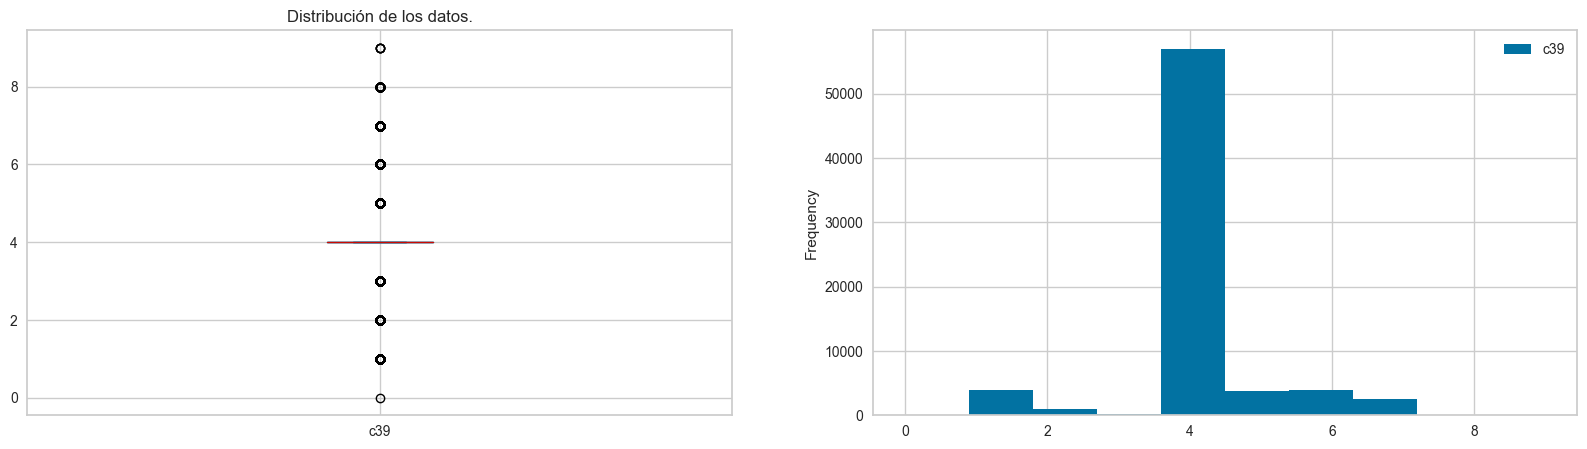

[+] VALUES_ENCODED	 ['150L' 'F' 'I' 'J' 'O' 'R' 'T' 'U' 'V' 'X' nan]
[+] SKEW	 -0.2776341324592938


,c39
count,72460
unique,10
top,O
freq,57019


In [77]:
categorical_histogram(col, df, bins=10)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

Existe un gran numero de datos faltantes, por lo tanto, se decide limitar la imputación en el numero de NaN consecutivos que exista.

In [78]:
# Calculo del limite: Mitad del porcentaje de valores faltantes
limit = int(round(nan_values * (1 - (perc_nan / 2) / 100)))
print(f'[+] LIMIT\t{limit}')

[+] LIMIT	84180


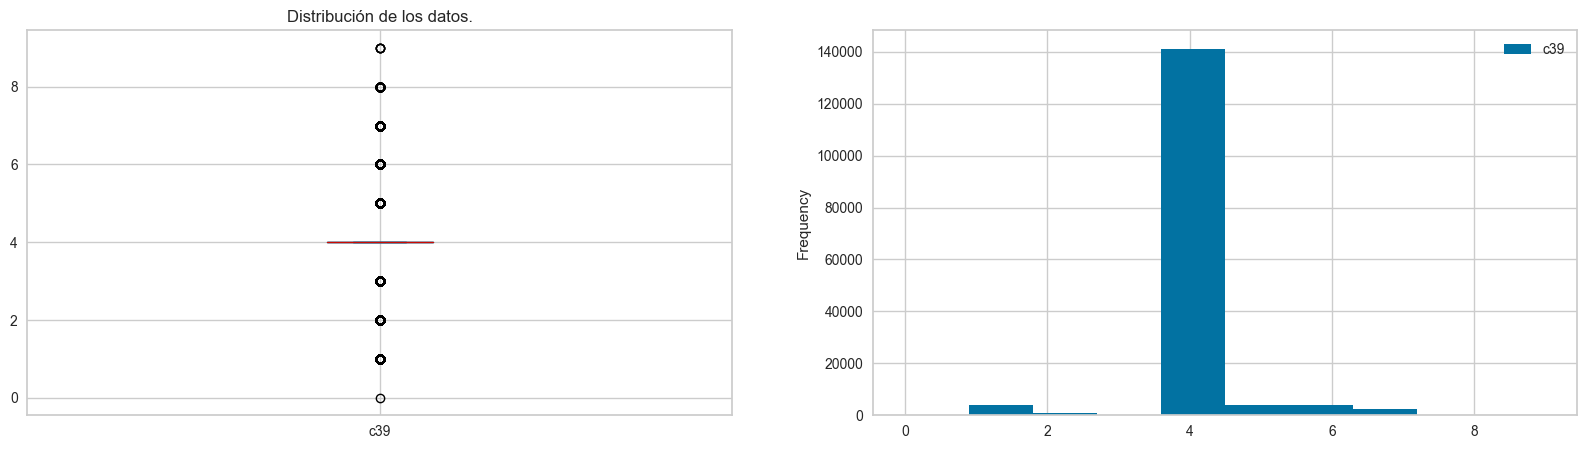

[+] VALUES_ENCODED	 ['150L' 'F' 'I' 'J' 'O' 'R' 'T' 'U' 'V' 'X' nan]
[+] SKEW	 -0.23090358969836564


,c39
count,156640
unique,10
top,O
freq,141199


In [79]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True, limit=limit)
categorical_histogram(col, df, bins=10)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c102: Primary type of flying code</b></div></h6>

In [80]:
col = 'c102'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Primary type of flying code 

[+] NAN_VALUES	28505	14.6 %


,c102
count,166747
unique,18
top,1
freq,84097


In [81]:
df['c102'] = df['c102'].map(lambda x: '8' if (x == '0') else x)

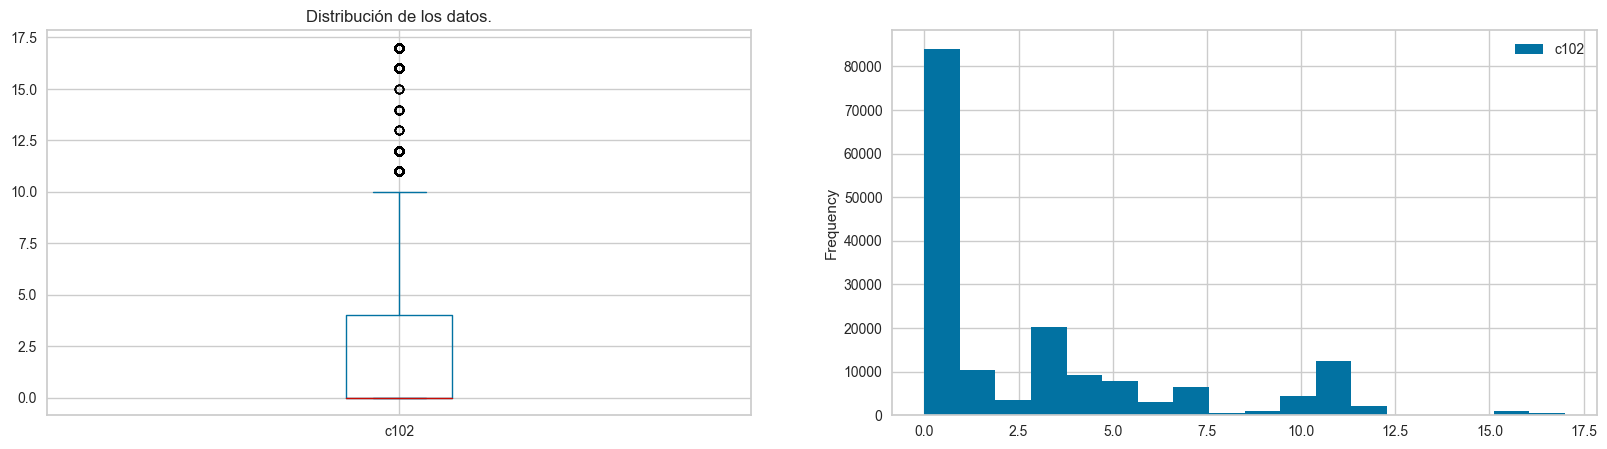

[+] VALUES_ENCODED	 ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J'
 nan]
[+] SKEW	 1.3926320279809676


,c102
count,166747
unique,18
top,1
freq,84097


In [82]:
categorical_histogram(col, df, bins=18)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

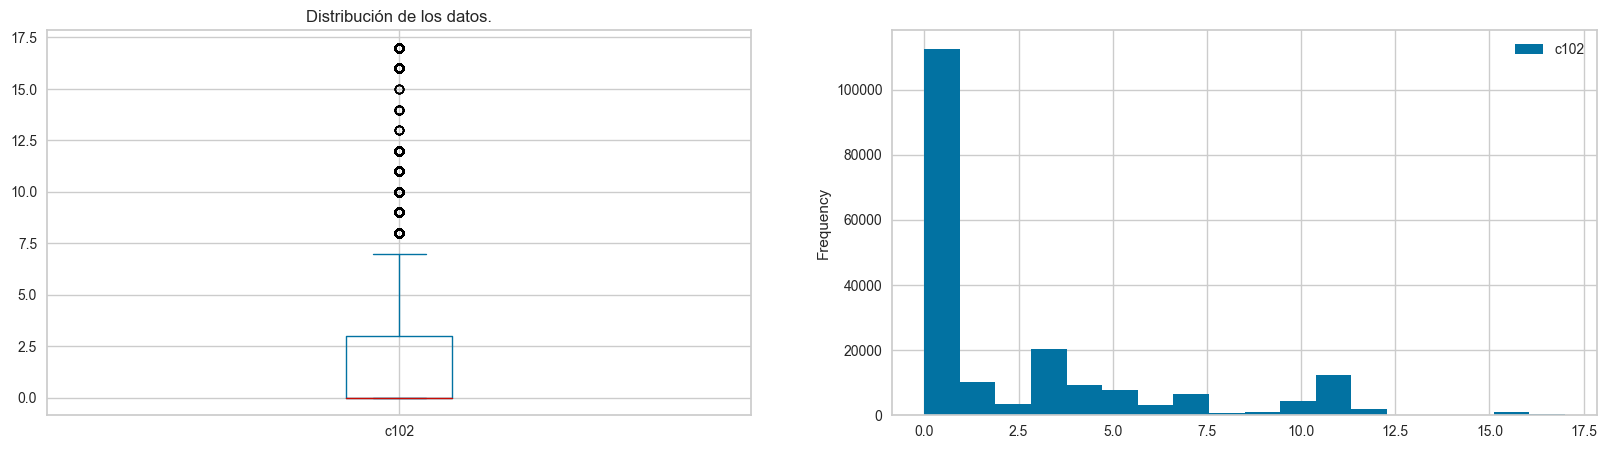

[+] VALUES_ENCODED	 ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J']
[+] SKEW	 1.6190459324106445


,c102
count,195252
unique,18
top,1
freq,112602


In [83]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True)
categorical_histogram(col, df, bins=18)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

##### <h6><div style="font-size:14px; text-align:left"><b>c104: Secondary type of flying code</b></div></h6>

In [84]:
col = 'c104'
print('[+] COL\t', col_name(col), '\n')
nan_values = df[[col]].isna().sum()[0]
perc_nan = round((nan_values/df.shape[0]) * 100, 2)
print(f'[+] NAN_VALUES\t{nan_values}\t{perc_nan} %')
df[[col]].describe()

[+] COL	 Secondary type of flying code 

[+] NAN_VALUES	28585	14.64 %


,c104
count,166667
unique,29
top,B
freq,72852


In [85]:
df['c104'] = df['c104'].map(lambda x: 'W' if (x in [0,'O','5']) else x)

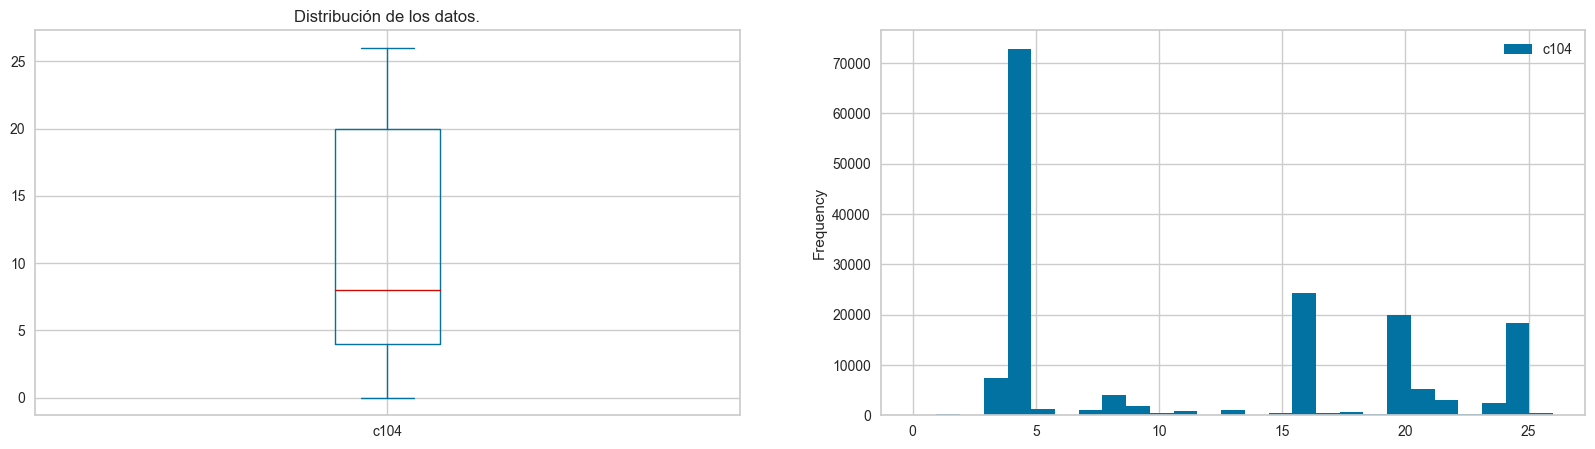

[+] VALUES_ENCODED	 ['1' '2' '3' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'P'
 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' nan]
[+] SKEW	 0.37265333366059666


,c104
count,166667
unique,27
top,B
freq,72852


In [86]:
categorical_histogram(col, df, bins=27)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

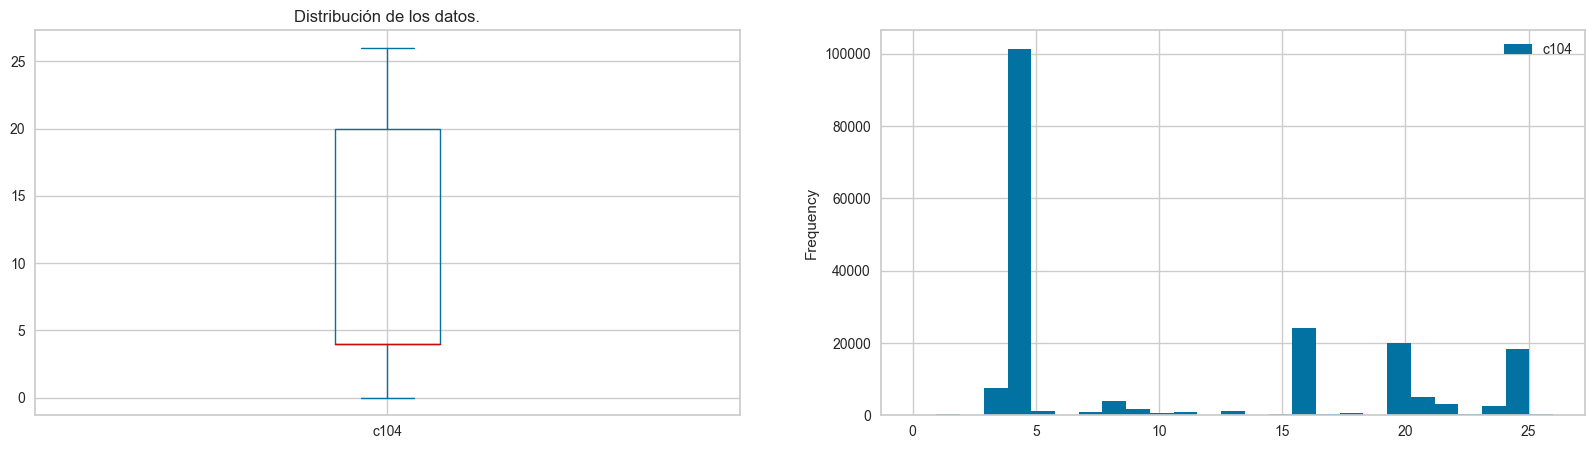

[+] VALUES_ENCODED	 ['1' '2' '3' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'P'
 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y']
[+] SKEW	 0.6326718607894654


,c104
count,195252
unique,27
top,B
freq,101437


In [87]:
# Imputación
df[col].fillna(df[col].mode()[0], inplace=True)
categorical_histogram(col, df, bins=27)
df[[col]].describe()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Distribución de los datos.</i></div>

<h3><div style="font-size:14px; text-align:center"><b>CONVERSIÓN DE DATOS</b></div></h3>

En este punto, se asegura que los atributos que ha quedado en el dataset, contiene el tipo de datos esperado.

- Basandonos en la información extraída previamente, la columna c7 (Month the accident/incident happened), tiene tipo de datos numérico, no obstante, este atributo ha de ser categórico ya que el mes del suceso tiene el mismo peso en todos los casos.
- La columna c96, tiene diferentes clases, pero para el modelo a estudiar, únicamente interesa si el avión se encontraba en vuelo, por lo tanto, se reducirá el numero de clases de modo que tengamos las clases:
    - **AIRBNE**: Airborne o en vuelo.
    - **T/O**: Takeoff o despegando.
    - **LDG**: Landing o aterrizando.
    - **GND**: Ground o en tierra.
    - **SPL**: Special o maniobras de vuelo especiales.
    - **OTH**: Others u otros.

<h4><div style="font-size:14px; text-align:left">Conversión c144</div></h4>

In [88]:
# Datos de la columna
df['c144'].unique()

array(['1L71', '1H71', '2L72', '2L74', '1L72', '1G71', '1H72', '1Q71',
       '2M74', '2H72', '2G71', '2M72', '2L73', '2G72', '1K71', '1M71',
       '1G72', '2H71', '2H73', '1L74', '1H73', '2H74', '2Q73', '1B72',
       '1D71', '2L71', '1M72', '2D74', '1H74', '1B71', '1K72', '1H81',
       '2X74', '2M71', '2S72', '2D71', '2Q72', '1X72', '1S71', '1W71',
       '1F71', '1L73', '1X71', '1P71', '1E71', '1K01', nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c145</div></h4>

In [89]:
# Datos de la columna
df['c145'].unique()

array(['1', '2', nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c147</div></h4>

In [90]:
# Datos de la columna
df['c147'].unique()

array(['L', 'H', 'G', 'Q', 'M', 'K', 'B', 'D', 'S', nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c149</div></h4>

In [91]:
# Datos de la columna
df['c149'].unique()

array(['7', '8', '0', nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c151</div></h4>

In [92]:
# Datos de la columnadf
df['c151'] = df['c151'].map(lambda x: 0 if np.isnan(x) else x)
df['c151'] = df['c151'].astype('int64')
df['c151'].unique()

array([1, 2, 4, 3, 0], dtype=int64)

<h4><div style="font-size:14px; text-align:left">Conversión c153</div></h4>

In [93]:
# Datos de la columna
df['c153'].unique()

array(['3', '4', nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c155</div></h4>

In [94]:
# Datos de la columna
df['c155'].unique()

array(['O', 'F', 'R', 'T', 'U', 'J', 'I', 'V', 'X', nan, 'B', 'W'],
      dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c157</div></h4>

In [95]:
# Datos de la columna
df['c157'].unique()

array(['TR', 'CV', 'F', 'O', 'T', 'R', nan, 'SD', 'SK', 'FL', 'AF', 'AH',
       'OT'], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c30</div></h4>

In [96]:
# Datos de la columna
df['c30'].unique()

array(['STRD', 'REST', 'EXPT', 'MULT', 'LIMT', nan, 'PROV'], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c31</div></h4>

In [97]:
# Datos de la columna
df['c31'].unique()

array([     0.,   5000.,  15000.,  10000.,  55000.,  25000.,  70000.,
        20000.,  30000.,     nan,  45000.,  60000.,  35000.,  95000.,
        50000.,  40000.,  65000.,  75000.,  80000., 100000.,  90000.,
        85000.])

<h4><div style="font-size:14px; text-align:left">Conversión c33</div></h4>

In [98]:
# Datos de la columna
df['c33'].unique()

array(['L', 'H', 'G', 'Q', 'M', 'K', 'B', 'D', 'O', 'S', '7', '1', '2',
       nan], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c34</div></h4>

In [99]:
# Datos de la columna
df['c34'].unique()

array(['CONT', 'PWA', 'LY-CON', 'LYC', 'FRANKL', 'FRNKLN', 'AERO',
       'GLADEN', 'ALLSN', 'AMT', 'AMTR', 'ARSRCH', 'JACOBS', 'WRIGHT',
       'PCKARD', 'TMECA', 'GULF', 'MCCULL', 'RROYCE', 'GE', 'NONE',
       'MCCULH', 'AMTRVW', 'JACOBP', 'FCD', 'DHAV', 'AMTRLC', 'AMTRRW',
       'DHAVXX', 'PIGMAN', 'PORSCH', 'ONAN', 'CFMINT', 'TEMECA', 'MNASCO',
       'GARRET', 'ROTAX', 'IAE', 'WARNER', 'IAME', 'ENMA', 'AMTRMC',
       'AMTRHD', 'XENOAH', 'LIMBA', 'GARRTT', 'AMTRWD', 'WSK', 'BOEING',
       'LIMBAH', 'AMTRBU', 'GROB', 'AMTRFR', 'VEDEN', 'WILINT', 'VEDENY',
       'WALTER', 'ALIDSG', 'ALVIS', 'AMTRRM', 'HIRTH', 'FORD', 'TELEDY',
       'PWC', 'ZMDB', 'TELMAT', 'MOSLER', 'HOUSAI', 'CFE', 'THIEL',
       'SZEKE', 'ARONCA', 'PZL', 'AMES', 'SUPAIR', 'JABIRU', 'CHEVY',
       'P&W', 'VW', 'TURBO', 'THIELT', 'BOMBAR', 'PRATT', 'HONDA',
       'AVCO L', 'LYCOMI', 'CONT M', 'MATTIT', 'PBS', 'ALLISO', 'P&W CA',
       'SUBARU', 'P & W', 'WILLIA', 'SOLAR', 'AMA/EX', 'CONTIN', 'TURBOM',
    

<h4><div style="font-size:14px; text-align:left">Conversión c35</div></h4>

In [100]:
# Datos de la columna
df['c35'].unique()

array(['O200A', 'GTSIO520D', 'JT8D15', ..., 'TIO-540-AB1AD', 'O-320-B2D',
       '250-C30M'], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c36</div></h4>

In [101]:
# Datos de la columna
df['c36'].unique()

array(['O360', 'O200', 'O520', ..., 'BA3', '700-D2', 'CB41B'],
      dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c38</div></h4>

In [102]:
# Datos de la columna
df['c38'].unique()

array(['EA', 'SO', 'NE', 'GL', 'EU', 'WP', 'SW', 'NM', 'CE', nan],
      dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c39</div></h4>

In [103]:
# Datos de la columna
df['c39'].unique()

array(['O', 'F', 'R', 'T', 'U', 'J', 'I', 'V', 'X', nan, '150L'],
      dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c102</div></h4>

In [104]:
# Datos de la columna
df['c102'].unique()

array(['1', '8', '2', '4', '7', '5', '6', '9', '3', 'B', 'A', 'C', 'H',
       'J', 'E', 'D', 'F', 'G'], dtype=object)

<h4><div style="font-size:14px; text-align:left">Conversión c104</div></h4>

In [105]:
# Datos de la columna
df['c104'].unique()

array(['N', 'K', 'F', 'B', 'C', 'R', 'S', 'A', 'T', 'Q', 'U', 'M', 'G',
       'P', 'H', 'L', 'J', 'I', 'E', 'W', 'V', 'X', 'D', 'Y', '2', '1',
       '3'], dtype=object)

## FEATURE ENGINEERING (FE)

A continuación, se realiza una serie de modificaciones en los datos para que estos puedan ser interpretados por el modelo.

In [106]:
df = df.drop(['c34', 'c35', 'c36'], axis=1)

In [107]:
# Separar datos categóricos de numericos y variable objetivo
cat_cols = []
num_cols = []
target = 'c1'
for col in df:
    if col == target:
        continue
    if df[col].dtype == 'object':
        cat_cols.append(col)
    elif df[col].dtype in ['int64']:
        num_cols.append(col)
        
print(f'[+] CAT_COLS\t{cat_cols}')
print(f'[+] NUM_COLS\t{num_cols}')

[+] CAT_COLS	['c144', 'c145', 'c147', 'c149', 'c153', 'c155', 'c157', 'c30', 'c33', 'c38', 'c39', 'c102', 'c104']
[+] NUM_COLS	['c151']


<h3><div style="font-size:14px; text-align:center"><b>CODIFICACIÓN DE DATOS CATEGÓRICOS</b></div></h3>

Existe una serie de columnas con datos categóricos que se deberá de codificar para poder tratar sus datos y realizar nuestra prediccion del modelo.<br>
Hasta ahora se ha trabajado con las columnas categóricas y numéricas em base a sus datos, pero, para realizar la codificación necesaria, se va a realizar sobre todas las columnas que necesariamente serán categóricas para realizar el modelo.<br>
Existe tres técnicas de Data Encoding dependiendo de las carácteristicas de los atributos:<br>
- OrdinalEncoder: Se utiliza para codificar variables categóricas que no tienen una relación de orden natural. Devuelve una unica columna que va de 1 a n_caracteristicas-1.
- LabelEncoder: Se utiliza para codificar variables categóricas que tienen una relación de orden natural. Devuelve una columna de 1 a n_caracteristicas-1. Su uso se realiza principalmente para transformar la variable dependiente.
- OneHotEncoder: Se utiliza para codificar variables categóricas que no tienen una relación de orden natural. Devuelve una columna para cada atributo codificado, indicando 0 o 1 según la presencia de la carateristica para cada registro.
<br>

A continuación se muestra los tipos de datos categoricos del dataset para seleccionar que tecnica emplear con cada atributo.

In [108]:
# LabelEncoder
col_le = [target]
# OrdinalEncoder
col_oe = ['c145', 'c147', 'c149', 'c153', 'c155', 'c33', 'c39', 'c102', 'c104']
# OneHotEncoder
#col_ohe = ['c144', 'c157', 'c30', 'c34', 'c35', 'c36', 'c38']
col_ohe = ['c144', 'c157', 'c30', 'c38']
# Cambio de tipo
col_retype = ['c151', 'c31']
col_oe.extend(col_retype)

Para aquellos atributos que sus datos categoricos, son todos numéricos, simplemente se les aplica un cambio de tipo de datos a entero para poder ser interpretado por el modelo, **col_retype**.
Para la variable dependiente u objetivo, c1, así como para los atributos de entrada cuyos datos tienen un orden de relación, se emplea LabelEncoder, **col_le**.
Para los atributos cuyas clases no están relacionadas, se emplea OrdinalEncoder y OneHotEncoder como ya se ha mencionado. Los atributos que poseen pocas clases y además tienen una mayor importancia en el significado del estudio, se ha decidido emplear OneHotEncoder **col_ohe**. Para el resto de columnas y sin un fuerte significado en el estudio, se ha realizado un OrdinalEncoder, **col_oe**.

<h4><div style="font-size:14px; text-align:left"><b>LabelEncoder</b></div></h4>

Para la transformación de los datos, se guarda el diccionario de los datos que se va a mapear para poder emplearlo en la entrada de nuevos datos.

In [109]:
# Instancia del codificador
le = LabelEncoder()

mapped_dic = {}
for col in col_le:
    # Ajuste de los datos y transformación
    df[col] = le.fit_transform(df[col])
    # Añadir valores al diccionario
    mapped_dic.update({col: dict(zip(le.transform(le.classes_), le.classes_))})
    
mapped_le = pd.DataFrame.from_dict(mapped_dic, orient='index').fillna('-')
mapped_le

,0,1,2
c1,A,I,-


<h4><div style="font-size:14px; text-align:left"><b>OrdinalEncoder</b></div></h4>

In [110]:
# Instancia del codificador
oe = OrdinalEncoder()

cat_cols_mapped = []
for col in col_oe:
    df[col] = oe.fit_transform(df[[col]])
    categories = list(oe.categories_[0])
    
    # Añadir valores al diccionario
    mapped_dic.update({col: {idx: cat for idx, cat in enumerate(categories)}})
    
    # Añadir columnas a lista de columnas transformadas
    cat_cols_mapped.append(col)

mapped_df = pd.DataFrame.from_dict(mapped_dic, orient='index').fillna('-')
mapped_df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
c1,A,I,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c145,1,2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c147,B,D,G,H,K,L,M,Q,S,-,...,-,-,-,-,-,-,-,-,-,-
c149,0,7,8,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c153,3,4,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
c155,B,F,I,J,O,R,T,U,V,W,...,-,-,-,-,-,-,-,-,-,-
c33,1,2,7,B,D,G,H,K,L,M,...,-,-,-,-,-,-,-,-,-,-
c39,150L,F,I,J,O,R,T,U,V,X,...,-,-,-,-,-,-,-,-,-,-
c102,1,2,3,4,5,6,7,8,9,A,...,J,-,-,-,-,-,-,-,-,-
c104,1,2,3,A,B,C,D,E,F,G,...,P,Q,R,S,T,U,V,W,X,Y


In [111]:
# Almacenar diccionario en .csv para su posterior uso
mapped_df.to_csv(f'{model_info_dir}mapped_dictionary.csv', index=True)

<h4><div style="font-size:14px; text-align:left"><b>OneHotEncoder</b></div></h4>

In [112]:
# Instancia del codificador
ohe = OneHotEncoder()

# Obtener los valores codificados
vals = ohe.fit_transform(df[col_ohe]).toarray()
feature_names = ohe.get_feature_names_out(col_ohe)

# Añadir columnas a lista de columnas transformadas
cat_cols_mapped.extend(feature_names)

# Creamos un DataFrame con las características codificadas OneHot
encoded_data = pd.DataFrame(vals, columns=feature_names)

# Concatenamos el DataFrame original con el DataFrame codificado OneHot
df = pd.concat([df.drop(col_ohe, axis=1), encoded_data], axis=1)

df.head()

,c1,c145,c147,c149,c151,c153,c155,c31,c33,c39,...,c38_CE,c38_EA,c38_EU,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan
0,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4><div style="font-size:14px; text-align:left"><b>Mapeado de datos</b></div></h4>

In [113]:
# Cambiar el tipo de datos a entero
#for col in col_retype:
#    df[col] = df[col].astype(int)
#    # Añadir columnas a lista de columnas transformadas
#    cat_cols_mapped.append(col)

<h3><div style="font-size:14px; text-align:center"><b>NORMALIZACIÓN ATRIBUTOS NUMÉRICOS</b></div></h3>

In [114]:
df[num_cols].describe()

,c151
count,195252.000000
mean,1.267931
std,0.602382
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


En base a la desviación estandar de determinadas columnas, que son elevadas, se realiza el normalizado de los datos y el escalado entre 0 y 1.

<h3><div style="font-size:14px; text-align:center"><b>CONCLUSION</b></div></h3>

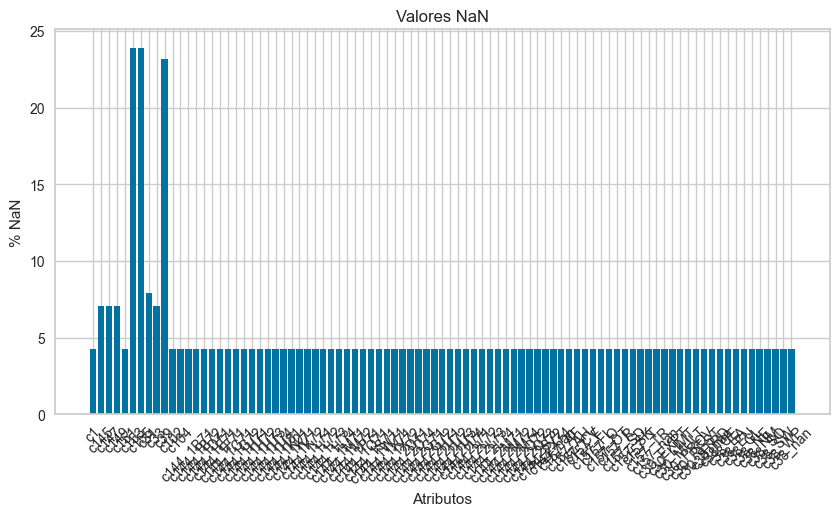

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203983 entries, 0 to 195249
Data columns (total 89 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   c1         195252 non-null  float64
 1   c145       189510 non-null  float64
 2   c147       189510 non-null  float64
 3   c149       189510 non-null  float64
 4   c151       195252 non-null  float64
 5   c153       155217 non-null  float64
 6   c155       155217 non-null  float64
 7   c31        187876 non-null  float64
 8   c33        189510 non-null  float64
 9   c39        156640 non-null  float64
 10  c102       195252 non-null  float64
 11  c104       195252 non-null  float64
 12  c144_1B71  195252 non-null  float64
 13  c144_1B72  195252 non-null  float64
 14  c144_1D71  195252 non-null  float64
 15  c144_1E71  195252 non-null  float64
 16  c144_1F71  195252 non-null  float64
 17  c144_1G71  195252 non-null  float64
 18  c144_1G72  195252 non-null  float64
 19  c144_1H71  195252 non-n

In [115]:
plot_nan(df)
df.info()

Eliminar NaN para poder predecir los modelos

In [116]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [117]:
corr = df.corr()
corr.style.background_gradient(cmap='Blues')

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Correlación de atributos.</i></div>

In [118]:
# Eliminar la diagonal principal y los valores debajo de esta, manteniendo solo los valores superiores
# para ver solo valores unicos diferentes de 1 (relacion con diferentes atributos)
corr_filter = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))

# Ordenar de mayor a menor
corr_sort = corr_filter.stack().sort_values(ascending=False).to_frame()

# Añadir nombres a las columnas para entender las relaciones
corr_sort = corr_sort.rename(columns=leyend_dict, index=leyend_dict)

corr_sort.head(10)

0
Type of the engine code.                           Piston, turbine, turboprop, etc.        0.999957
Wing information of the aircraft involved in th... Low wing, high wing, rotary wing, etc.  0.990144
Code for Weight  Class                             Primary type of flying code             0.702519
                                                   Number of engines on aircraft           0.697053
c157_nan                                           c30_nan                                 0.682556
c157_TR                                            c30_STRD                                0.669064
Number of engines on aircraft                      Primary type of flying code             0.598444
Primary type of flying code                        Secondary type of flying code           0.554691
Code for Weight  Class                             Under or over 750 hp.                   0.447493
                                                   Secondary type of flying code           0.363306

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Correlación de atributos.</i></div>

<div style="text-align:justify">Tras la transformación de los datos categóricos, se ha modificado todos los atributos, de modo que pueda ser interpretado por el modelo. Además, se ha aumentado el numero de columnas al realizar la imputación OneHotEncoder en varios de los atributos.<br>
    Se observa además, que los datos no están fuertemente ligados, pero, si que en cuanto a lógica de correlaciones, se obtiene resultados esperados.</div>

## DATA MODELING

Crear el modelo de predicción con el conjunto de datos obtenido.

<h3><div style="font-size:14px; text-align:center"><b>DIVISION DE LOS DATOS</b></div></h3>

Para el modelado, se emplea unos datos de entrenamiento (train) y unos de prueba (test). Una vez el modelo está realizado, existe los datos de validación, estos no son vistos por el modelo durante el train o test.

A continuación, se parte los datos en:
- **data**: datos con los que se entrenará y testeará el modelo.
- **data_unseen**: datos que se emplearán para la validación (5% de los datos).

In [119]:
## sample devuelve una muestra aleatoria de un eje del objeto
data = df.sample(frac=0.95, random_state=786)
data

,c1,c145,c147,c149,c151,c153,c155,c31,c33,c39,...,c38_CE,c38_EA,c38_EU,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan
20671,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85350,1.0,1.0,5.0,1.0,4.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17422,1.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4618,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62426,1.0,0.0,5.0,1.0,2.0,0.0,4.0,2.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62465,0.0,0.0,5.0,1.0,1.0,0.0,5.0,0.0,8.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31209,0.0,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144421,0.0,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
106779,1.0,1.0,5.0,1.0,3.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Datos modelado.</i></div>

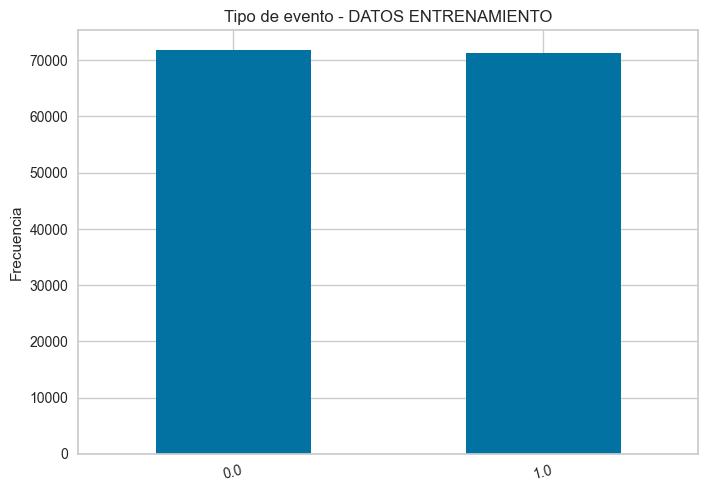

In [120]:
ax = data.c1.value_counts().plot(kind='bar', title='Tipo de evento - DATOS ENTRENAMIENTO')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Balanceo de clases para estudio del modelo.</i></div>

Para el entrenamiento, existe un desbalanceo hacia la clase 0 (Accidente) por lo que se deberá tener en cuenta este a la hora del entrenamiento.

In [121]:
# eliminamos del conjunto de datos original estos datos aleatorios para la validación
data_unseen = df.drop(data.index)
data_unseen

,c1,c145,c147,c149,c151,c153,c155,c31,c33,c39,...,c38_CE,c38_EA,c38_EU,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan
57,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150496,0.0,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
150514,0.0,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
150522,0.0,1.0,5.0,1.0,2.0,1.0,1.0,2.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
150555,0.0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Conjunto de validación.</i></div>

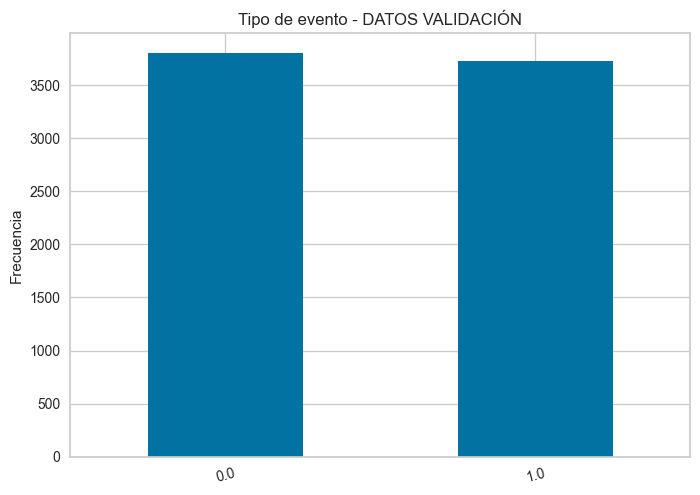

In [122]:
# Balanceo de los datos para la validación
ax = data_unseen.c1.value_counts().plot(kind='bar', title='Tipo de evento - DATOS VALIDACIÓN')

ax.set_ylabel('Frecuencia')

# Rotar nombres de atributos
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(15)

plt.show()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Balanceo datos de validación.</i></div>

In [123]:
## restablecemos el índice de ambos conjuntos de datos
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('[+] MODELING_DATA\t', len(data))
print('[+] VALIDATION_DATA\t',  len(data_unseen))

[+] MODELING_DATA	 143040
[+] VALIDATION_DATA	 7528


<h3><div style="font-size:14px; text-align:center"><b>PyCaret SETUP</b></div></h3>

Para la configuraciones de nuestro clasificador, se emplea el metodo **setup()** de PyCaret, en el cual se le indica aquellos parámetros necesarios para realizar los modelos:
- **fold_strategy**: Permite seleccionar una técnica de validación cruzada.
- **preprocess**: Existe la posibilidad de introducir datos ya preprocesados y por lo tanto indicar unicamente el pipeline de transformaciones que se desea (valor a False). O por el contrario, que PyCaret preprocese los datos para realizar imputacioens, codificacion de caracteristicas... (valor a True).
- **pca**: Se permite el uso de reducción de dimensionalidad con el uso de Principal Component Analysis.
- **low_variance_threshold**: Ignorar varianzas bajas en aquellos casos en los que existe una caracterisitca dominante sobre otras relacionadas y no existe mucha variación en la informaciñon de estas caracteristicas.
- **remove_multicollinearity**: Permite lidiar con las caracteristicas que están fuertemente ligadas con otras del dataset.
- **fix_imbalance**: Cuando existe un conjunto de datos desbalanceado, se permite balancear este mediante diferentes técnicas.
- **remove_outliers**: Eliminación de outliers en el conjunto de los datos.

In [124]:
model_setup = setup(
    data=data, target='c1',
    verbose=True, n_jobs=-1, session_id=2023051,
    # Validación cruzada
    fold_strategy = 'kfold', fold = 10, fold_shuffle=True,
    # Indicar datos
    categorical_features=cat_cols_mapped, numeric_features=num_cols,
    # Pipeline de transformaciones
    preprocess=False,  # custom_pipeline=transformer_pipeline,
    # Analisis de componentes principales
    pca = True, pca_method='incremental',  pca_components=20,
    # Ignorar varianzas bajas
    low_variance_threshold=None,
    # Correlacion de variables
    remove_multicollinearity=True,  multicollinearity_threshold=0.95,
                                     # Poner a True y probar
    # Desbalaceo
    fix_imbalance=False,
    # Outliers
    remove_outliers=False
)

,Description,Value
0,Session id,2023051
1,Target,c1
2,Target type,Binary
3,Original data shape,"(143040, 89)"
4,Transformed data shape,"(143040, 89)"
5,Transformed train set shape,"(100128, 89)"
6,Transformed test set shape,"(42912, 89)"
7,Numeric features,1
8,Categorical features,88


In [125]:
get_config('X_train')

,c145,c147,c149,c151,c153,c155,c31,c33,c39,c102,...,c38_CE,c38_EA,c38_EU,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan
85168,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
119036,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31102,1.0,5.0,1.0,2.0,0.0,4.0,1.0,8.0,4.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29202,0.0,2.0,1.0,1.0,0.0,4.0,1.0,5.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108468,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128693,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83828,0.0,5.0,1.0,1.0,0.0,5.0,2.0,8.0,5.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52178,0.0,5.0,1.0,1.0,0.0,4.0,1.0,8.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131847,1.0,5.0,1.0,3.0,0.0,4.0,0.0,8.0,4.0,11.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Datos de entrenamiento.</i></div>

Conjunto de entrenamiento creado por el setup de pycaret.

<h3><div style="font-size:14px; text-align:center"><b>COMPARACIÓN DE MODELOS</b></div></h3>

In [126]:
test_models = models()
test_models_id = [i[0] for i in test_models.iterrows() if i[1]["Turbo"] == True]
print(test_models_id)
test_models

['lr', 'knn', 'nb', 'dt', 'svm', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'dummy']


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Modelos disponibles PyCaret.</i></div>

De los modelos disposnibles, se realiza una comprobación de sus predicciones ordenados por la **Sensibilidad (Recall)** para poder compararlos y escoger el mejor de ellos.

Dada la importancia de la predicción, es importante escoger un modelo cuya proporción de verdaderos positivos en relación con el total de muestras positivas en el conjunto de datos sea lo más elevada posible.

In [127]:
compare_models(cross_validation=False, include=test_models_id, probability_threshold=0.5, sort='Recall')
#compare_models(cross_validation=False, probability_threshold=0.5, sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.5064,0.5078,0.9987,0.5024,0.6686,0.0157,0.0825,0.0100
nb,Naive Bayes,0.5072,0.6792,0.9978,0.5029,0.6687,0.0172,0.0831,0.1000
lightgbm,Light Gradient Boosting Machine,0.7118,0.7938,0.6924,0.7190,0.7055,0.4235,0.4238,0.0200
xgboost,Extreme Gradient Boosting,0.7117,0.7928,0.6809,0.7242,0.7019,0.4232,0.4240,0.0400
et,Extra Trees Classifier,0.6934,0.7608,0.6773,0.6985,0.6877,0.3867,0.3869,0.3900
dt,Decision Tree Classifier,0.6895,0.7419,0.6751,0.6937,0.6843,0.3789,0.3790,0.0200
gbc,Gradient Boosting Classifier,0.6990,0.7807,0.6720,0.7089,0.6900,0.3978,0.3984,0.0200
rf,Random Forest Classifier,0.6981,0.7728,0.6674,0.7096,0.6879,0.3960,0.3967,0.2800
knn,K Neighbors Classifier,0.6729,0.7417,0.6343,0.6859,0.6591,0.3456,0.3466,0.0400
ada,Ada Boost Classifier,0.6849,0.7628,0.6155,0.7130,0.6607,0.3695,0.3730,0.0200


CustomProbabilityThresholdClassifier(classifier=QuadraticDiscriminantAnalysis(priors=None,
                                                                              reg_param=0.0,
                                                                              store_covariance=False,
                                                                              tol=0.0001),
                                     priors=None, probability_threshold=0.5,
                                     reg_param=0.0, store_covariance=False,
                                     tol=0.0001)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Comparación de modelos.</i></div>

Teniendo en cuenta los resultados obtenidos, en cuanto a métricas y tiempos de ejecución, se decide escoger un top 3 para crear los modelos, poder ajustarlos y finalmente realizar el modelo con el mejor de ellos. En base a ello, se escoge:
- Extreme Gradient Boosting (xgboost)
- CatBoost Classifier (catboost)
- Random Forest Classifier (rf)

A continuación, se muestra la comparación de los modelos, esta vez, empleando la validación cruzada con 10 folds como se ha indicado en los ajustes.

In [128]:
compare_models(cross_validation=True, include=['lightgbm', 'xgboost', 'qda'], probability_threshold=0.5, sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7123,0.7949,0.6913,0.7203,0.7055,0.4246,0.4249,1.0370
xgboost,Extreme Gradient Boosting,0.7112,0.7946,0.6864,0.7210,0.7032,0.4224,0.4229,0.2880
qda,Quadratic Discriminant Analysis,0.5093,0.5098,0.5748,0.5206,0.4616,0.0195,0.0351,0.2670


CustomProbabilityThresholdClassifier(boosting_type='gbdt', class_weight=None,
                                     classifier=LGBMClassifier(boosting_type='gbdt',
                                                               class_weight=None,
                                                               colsample_bytree=1.0,
                                                               importance_type='split',
                                                               learning_rate=0.1,
                                                               max_depth=-1,
                                                               min_child_samples=20,
                                                               min_child_weight=0.001,
                                                               min_split_gain=0.0,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_leaves=31,
                                                               objective=None,
                                                               random_state=2...
                                                               subsample_freq=0),
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, probability_threshold=0.5,
                                     random_state=2023051, reg_alpha=0.0,
                                     reg_lambda=0.0, silent='warn',
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Comparación de 3 mejores modelos.</i></div>

<h3><div style="font-size:14px; text-align:center"><b>CREACIÓN DEL MODELO</b></div></h3>

En base a los resultados anteriores, se escoge el modelo **Extreme Gradient Boosting** para realizar las predicciones.

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7188,0.7989,0.6986,0.7333,0.7155,0.4378,0.4383
1,0.7002,0.7825,0.6788,0.7122,0.6951,0.4005,0.4010
2,0.7089,0.7915,0.6849,0.7164,0.7003,0.4176,0.4180
3,0.7127,0.8025,0.6852,0.7222,0.7032,0.4251,0.4257
4,0.7061,0.7885,0.6877,0.7107,0.6990,0.4120,0.4122
5,0.7191,0.8004,0.7049,0.7228,0.7137,0.4380,0.4382
6,0.7180,0.8029,0.6987,0.7251,0.7117,0.4358,0.4361
7,0.7175,0.7947,0.6969,0.7258,0.7111,0.4349,0.4352
8,0.7114,0.7915,0.6935,0.7133,0.7032,0.4226,0.4227


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7169,0.7984,0.7001,0.7296,0.7146,0.4339,0.4343
1,0.7004,0.7840,0.6828,0.7107,0.6965,0.4009,0.4012
2,0.7101,0.7927,0.6875,0.7171,0.7020,0.4200,0.4203
3,0.7160,0.8019,0.6860,0.7269,0.7059,0.4317,0.4324
4,0.7061,0.7883,0.6830,0.7127,0.6976,0.4119,0.4123
5,0.7165,0.8009,0.6963,0.7229,0.7093,0.4328,0.4331
6,0.7182,0.8033,0.6951,0.7271,0.7107,0.4362,0.4367
7,0.7173,0.7954,0.6933,0.7272,0.7098,0.4345,0.4349
8,0.7103,0.7913,0.6979,0.7097,0.7038,0.4204,0.4205


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7176,0.7981,0.7017,0.7299,0.7156,0.4353,0.4357
1,0.7010,0.7819,0.6822,0.7119,0.6967,0.4021,0.4025
2,0.7091,0.7916,0.6847,0.7168,0.7004,0.4180,0.4184
3,0.7131,0.8001,0.6856,0.7227,0.7037,0.4259,0.4265
4,0.7046,0.7878,0.6842,0.7100,0.6969,0.4090,0.4092
5,0.7186,0.8008,0.7035,0.7227,0.7130,0.4370,0.4372
6,0.7183,0.8037,0.6959,0.7269,0.7111,0.4364,0.4368
7,0.7167,0.7950,0.6935,0.7262,0.7095,0.4333,0.4337
8,0.7079,0.7909,0.6949,0.7074,0.7011,0.4154,0.4155


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7185,0.7971,0.6990,0.7326,0.7154,0.4372,0.4376
1,0.7030,0.7820,0.6810,0.7154,0.6978,0.4061,0.4066
2,0.7109,0.7923,0.6873,0.7184,0.7025,0.4216,0.4219
3,0.7133,0.8005,0.6866,0.7225,0.7041,0.4263,0.4269
4,0.7015,0.7862,0.6812,0.7067,0.6937,0.4028,0.4030
5,0.7181,0.8001,0.7031,0.7221,0.7125,0.4360,0.4362
6,0.7166,0.8001,0.6985,0.7231,0.7106,0.4331,0.4333
7,0.7141,0.7933,0.6917,0.7231,0.7071,0.4281,0.4285
8,0.7086,0.7893,0.6937,0.7090,0.7013,0.4170,0.4171


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7143,0.7950,0.6946,0.7284,0.7111,0.4288,0.4293
1,0.7007,0.7818,0.6804,0.7122,0.6960,0.4015,0.4019
2,0.7025,0.7873,0.6771,0.7103,0.6933,0.4048,0.4052
3,0.7146,0.8000,0.6894,0.7232,0.7059,0.4290,0.4294
4,0.7012,0.7834,0.6873,0.7037,0.6954,0.4022,0.4023
5,0.7154,0.7977,0.6927,0.7229,0.7075,0.4306,0.4309
6,0.7144,0.8000,0.6949,0.7215,0.7079,0.4287,0.4289
7,0.7132,0.7919,0.6823,0.7262,0.7036,0.4263,0.4270
8,0.7070,0.7886,0.6927,0.7070,0.6998,0.4136,0.4137


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7128,0.7946,0.6972,0.7249,0.7108,0.4257,0.4261
1,0.6987,0.7790,0.6768,0.7108,0.6934,0.3976,0.3980
2,0.7063,0.7883,0.6752,0.7169,0.6955,0.4123,0.4130
3,0.7104,0.7962,0.6822,0.7201,0.7007,0.4205,0.4211
4,0.7032,0.7828,0.6770,0.7111,0.6936,0.4061,0.4066
5,0.7140,0.7968,0.7005,0.7172,0.7088,0.4278,0.4280
6,0.7166,0.8005,0.6949,0.7248,0.7095,0.4330,0.4334
7,0.7117,0.7899,0.6865,0.7219,0.7037,0.4233,0.4238
8,0.7048,0.7881,0.6882,0.7057,0.6968,0.4092,0.4093


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7111,0.7899,0.6944,0.7237,0.7087,0.4224,0.4227
1,0.6989,0.7756,0.6665,0.7158,0.6903,0.3980,0.3990
2,0.7017,0.7852,0.6660,0.7141,0.6892,0.4031,0.4040
3,0.7113,0.7951,0.6824,0.7214,0.7014,0.4223,0.4229
4,0.6992,0.7797,0.6708,0.7078,0.6888,0.3981,0.3987
5,0.7151,0.7957,0.6973,0.7203,0.7086,0.4300,0.4302
6,0.7131,0.7943,0.6899,0.7218,0.7055,0.4260,0.4265
7,0.7097,0.7875,0.6761,0.7237,0.6991,0.4193,0.4202
8,0.7056,0.7856,0.6947,0.7041,0.6994,0.4109,0.4109


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7137,0.7890,0.6863,0.7315,0.7082,0.4277,0.4285
1,0.6970,0.7767,0.6669,0.7127,0.6891,0.3942,0.3951
2,0.7010,0.7832,0.6734,0.7097,0.6911,0.4017,0.4023
3,0.7081,0.7941,0.6772,0.7190,0.6974,0.4159,0.4166
4,0.6984,0.7782,0.6714,0.7063,0.6884,0.3965,0.3970
5,0.7103,0.7896,0.6846,0.7189,0.7013,0.4204,0.4208
6,0.7112,0.7929,0.6870,0.7203,0.7033,0.4222,0.4227
7,0.7098,0.7865,0.6719,0.7259,0.6979,0.4195,0.4206
8,0.7017,0.7831,0.6833,0.7031,0.6931,0.4030,0.4031


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7083,0.7854,0.6871,0.7229,0.7046,0.4168,0.4174
1,0.6956,0.7751,0.6687,0.7098,0.6887,0.3914,0.3921
2,0.7035,0.7826,0.6758,0.7124,0.6936,0.4067,0.4073
3,0.7039,0.7892,0.6732,0.7144,0.6932,0.4075,0.4082
4,0.6958,0.7777,0.6746,0.7011,0.6876,0.3914,0.3917
5,0.7085,0.7881,0.6820,0.7173,0.6992,0.4168,0.4173
6,0.7087,0.7918,0.6891,0.7156,0.7021,0.4173,0.4176
7,0.7046,0.7817,0.6779,0.7151,0.6960,0.4091,0.4096
8,0.6997,0.7805,0.6882,0.6983,0.6932,0.3991,0.3991


<AxesSubplot: >

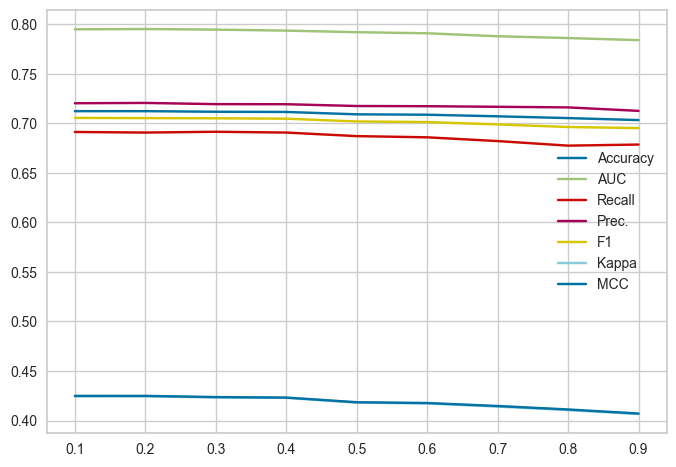

In [129]:
models = []
results = []

for i in np.arange(0.1,1,0.1):
    model = create_model('lightgbm', cross_validation=True, learning_rate = i, verbose=True)
    model_results = pull().loc[['Mean']]
    models.append(model)
    results.append(model_results)
    
results = pd.concat(results, axis=0)
results.index = np.arange(0.1,1,0.1)
results.plot()

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Tasa de aprendizaje.</i></div>

In [130]:
results.style.highlight_max(color = 'lightgreen', axis = 0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0.100000,0.712300,0.794900,0.691300,0.720300,0.705500,0.424600,0.424900
0.200000,0.712300,0.795200,0.690700,0.720600,0.705300,0.424500,0.424900
0.300000,0.711700,0.794600,0.691500,0.719400,0.705100,0.423400,0.423700
0.400000,0.711500,0.793600,0.690700,0.719300,0.704700,0.422900,0.423200
0.500000,0.709100,0.792000,0.687100,0.717500,0.701900,0.418100,0.418500
0.600000,0.708700,0.790900,0.685900,0.717300,0.701300,0.417300,0.417700
0.700000,0.707100,0.787900,0.682100,0.716700,0.698900,0.414100,0.414700
0.800000,0.705300,0.786100,0.677500,0.716100,0.696300,0.410600,0.411200
0.900000,0.703300,0.784000,0.678600,0.712600,0.695200,0.406600,0.407100


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Tasa de aprendizaje, estadísticas.</i></div>

Tras la creación del modelo teniendo en cuenta su tasa de aprendizaje, se establece esta en 0.5.

In [131]:
model = create_model('xgboost', cross_validation=True, learning_rate = 0.5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7142,0.7980,0.6893,0.7308,0.7094,0.4287,0.4294
1,0.7013,0.7825,0.6772,0.7145,0.6954,0.4028,0.4033
2,0.7062,0.7883,0.6742,0.7172,0.6951,0.4121,0.4128
3,0.7137,0.7995,0.6786,0.7270,0.7019,0.4271,0.4280
4,0.7036,0.7849,0.6826,0.7092,0.6957,0.4070,0.4073
5,0.7180,0.7994,0.6945,0.7260,0.7099,0.4358,0.4362
6,0.7151,0.7993,0.6959,0.7221,0.7087,0.4301,0.4303
7,0.7110,0.7921,0.6887,0.7198,0.7039,0.4219,0.4223
8,0.7079,0.7894,0.6876,0.7105,0.6989,0.4153,0.4155


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Modelo de prediccion.</i></div>

<h3><div style="font-size:14px; text-align:center"><b>AJUSTAR EL MODELO</b></div></h3>

In [132]:
model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Datos del modelo.</i></div>

Ya que se ha seleccionado el modelo en base a Recall, el parametro de Accuracy es más bajo, por lo que se decide ajustar el modelo teniendo en cuenta este parámetro.

In [133]:
tuned_model = tune_model(model, optimize='Accuracy', n_iter=20, choose_better=True)  # , custom_grid=param_grid)
tuned_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5762,0.7814,0.9846,0.5450,0.7017,0.1434,0.2539
1,0.5691,0.7688,0.9863,0.5394,0.6974,0.1331,0.2447
2,0.5679,0.7792,0.9839,0.5353,0.6934,0.1405,0.2503
3,0.5677,0.7864,0.9847,0.5353,0.6936,0.1398,0.2506
4,0.5638,0.7718,0.9839,0.5327,0.6912,0.1329,0.2418
5,0.5694,0.7861,0.9857,0.5362,0.6946,0.1432,0.2557
6,0.5718,0.7863,0.9868,0.5383,0.6966,0.1461,0.2603
7,0.5669,0.7770,0.9864,0.5358,0.6944,0.1354,0.2478
8,0.5648,0.7795,0.9850,0.5317,0.6906,0.1396,0.2511


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Ajuste del modelo.</i></div>

Aunque se observa como Recall sube bastantes puntos, el resto de estimadores bajan, y además ACcuracy baja en exceso, es por esto que se decide finalizar el modelo, con el modelo prmiero sin su ajuste.

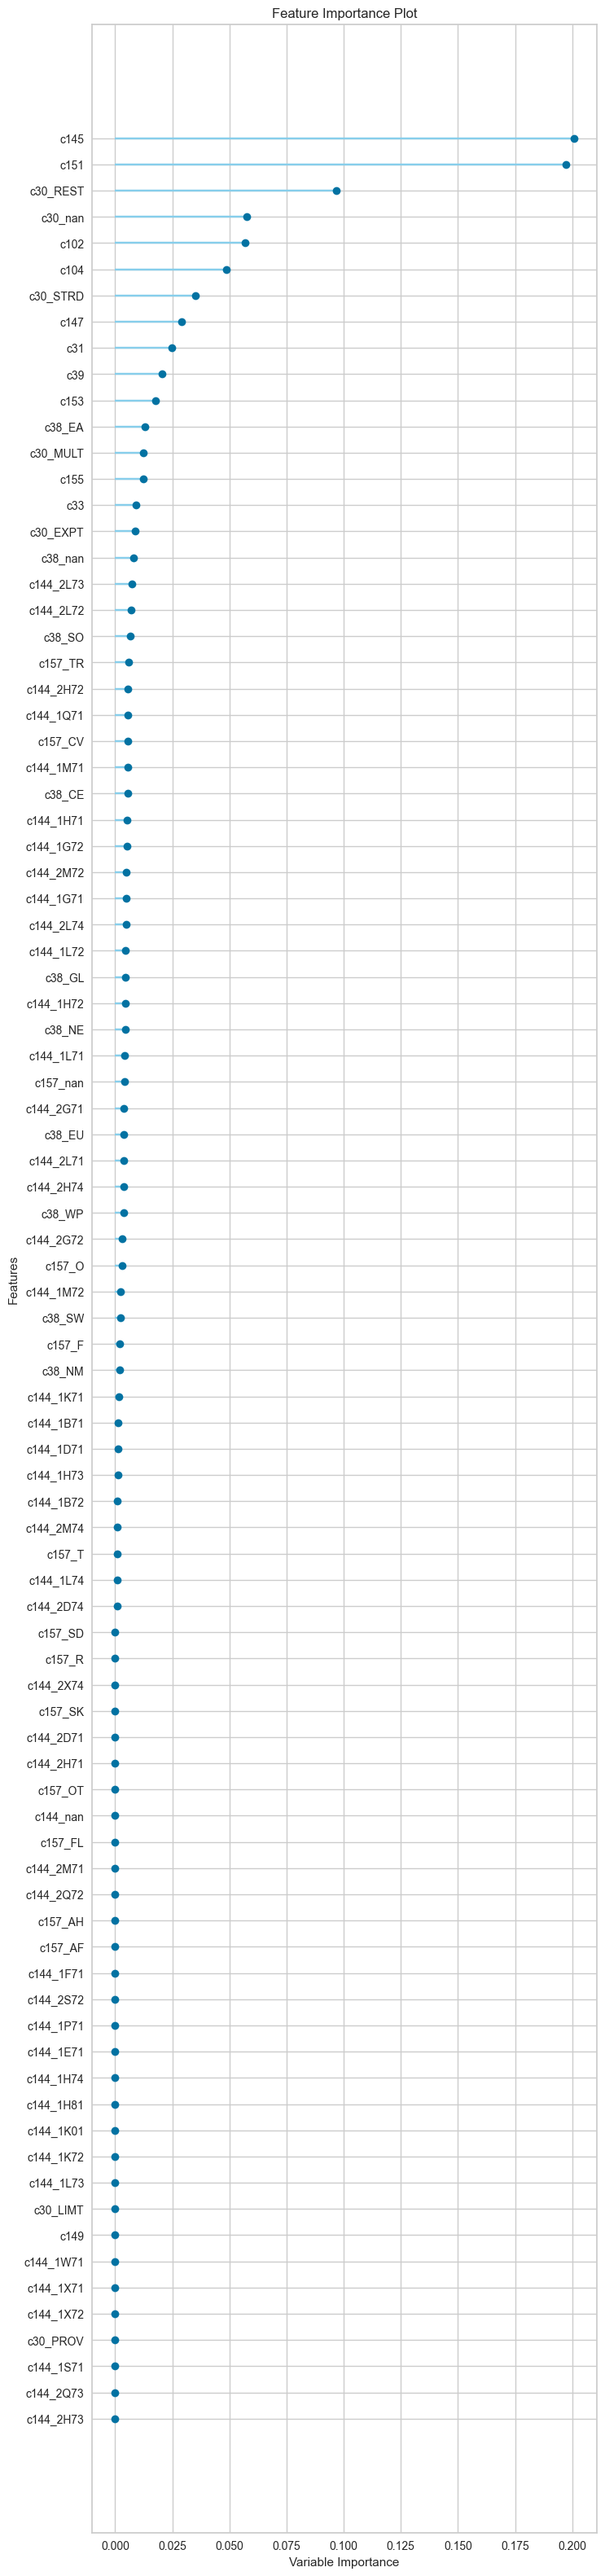

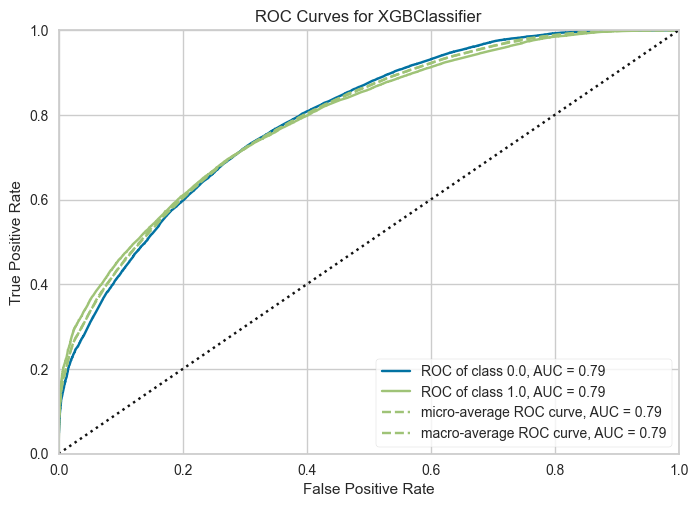

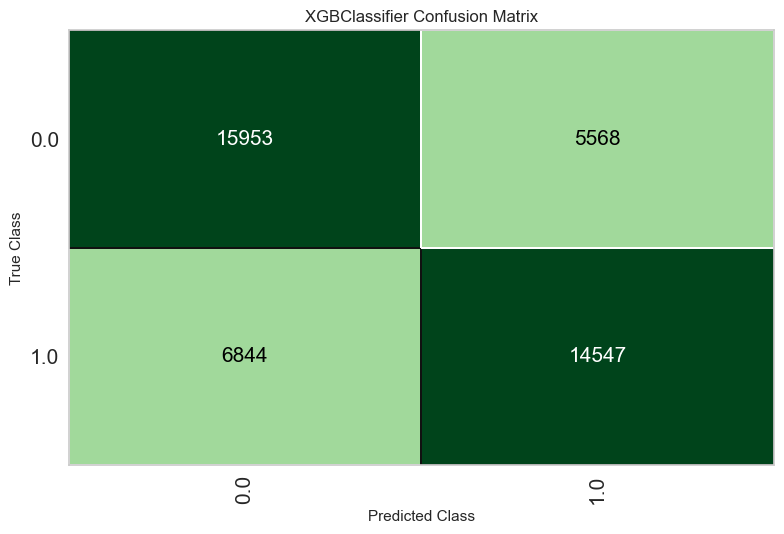

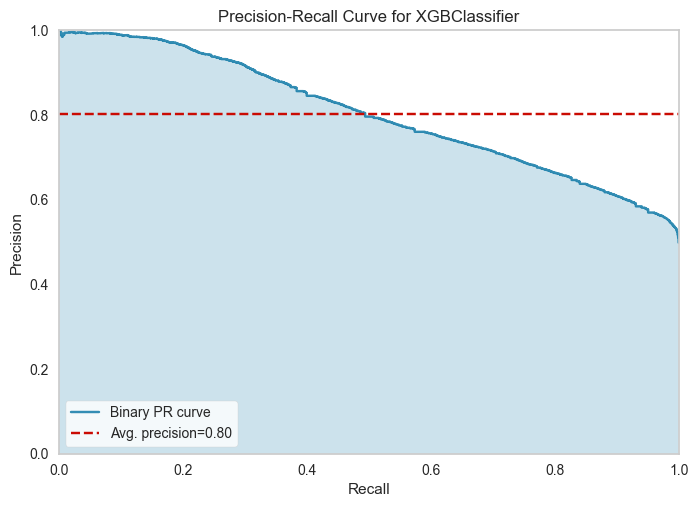

[None, None, None, None]

In [134]:
plots = ['feature_all', 'auc', 'confusion_matrix', 'pr']
list(map(lambda x: plot_model(model, plot=x), plots))

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Métricas del modelo.</i></div>

<h3><div style="font-size:14px; text-align:center"><b>FINALIZAR EL MODELO</b></div></h3>

Con el mejor de los modelos seleccionado y ajustado, se ajusta el modelo al conjunto de todos los datos, incluyendo test y train. Realizando finalmente una predicción sobre el conjunto de datos que se extrajo en un principio y no se han usado durante todo el proceso de creación del modelo.

In [135]:
final_model = finalize_model(model)
final_model

Pipeline(memory=FastMemory(location=C:\Users\pablo\AppData\Local\Temp\joblib),
         steps=[('placeholder', None),
                ('actual_estimator',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=N...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               objective='binary:logistic', predictor=None, ...))],
         verbose=False)

<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Creación del modelo final.</i></div>

Ya con el modelo creado, pasamos a realizar las predicciones con los datos que se ha reservado para ello.

In [136]:
# Prediccion sobre el conjunto de test
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7241,0.8105,0.6973,0.7354,0.7159,0.4480,0.4486


,c145,c147,c149,c151,c153,c155,c31,c33,c39,c102,...,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan,c1,prediction_label,prediction_score
51753,0.0,5.0,1.0,1.0,0.0,4.0,1.0,8.0,4.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5662
90601,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.6676
32788,0.0,5.0,1.0,1.0,0.0,4.0,1.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.6120
73484,0.0,7.0,1.0,1.0,0.0,5.0,1.0,11.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.8137
125072,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.5686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57036,0.0,6.0,1.0,1.0,0.0,4.0,1.0,9.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.5424
114312,0.0,5.0,1.0,1.0,0.0,4.0,2.0,8.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.5020
85539,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.5992
43968,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.5885


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Predicción sobre todos los datos.</i></div>

In [137]:
# Predicción sobre el conjunto de datos unseen
predict_model(final_model, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7161,0.7997,0.7000,0.7195,0.7096,0.4321,0.4322


,c145,c147,c149,c151,c153,c155,c31,c33,c39,c102,...,c38_GL,c38_NE,c38_NM,c38_SO,c38_SW,c38_WP,c38_nan,c1,prediction_label,prediction_score
0,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.9359
1,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.7135
2,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.9546
3,0.0,3.0,1.0,1.0,0.0,4.0,0.0,6.0,4.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.6725
4,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.9997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7523,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.5790
7524,0.0,3.0,1.0,1.0,0.0,4.0,1.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.6064
7525,1.0,5.0,1.0,2.0,1.0,1.0,2.0,8.0,1.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.8405
7526,0.0,5.0,1.0,1.0,0.0,4.0,0.0,8.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.5668


<div style="font-size:12px; text-align:center"><i><b>Tabla: </b>Prediccion sobre datos de validación.</i></div>

<h3><div style="font-size:14px; text-align:center"><b>GUARDAR EL MODELO</b></div></h3>

Tras todo el proceso de modelado y ajuste del mismo, para poder utilizar el modelo en un entorno de producción, es necesario guardar el mismo. Para ello, se emplea las propias herramientas de PyCaret.

In [138]:
# Registrar la hora actual para el guardado del modelo
date = datetime.now()
date = date.strftime('%Y%m%d_%H%M')

# Guardado del modelo
model_name = 'Aierplane_model'
save_model(final_model, f'{model_info_dir}{model_name}_{date}')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\pablo\AppData\Local\Temp\joblib),
          steps=[('placeholder', None),
                 ('actual_estimator',
                  XGBClassifier(base_score=None, booster='gbtree',
                                callbacks=None, colsample_bylevel=None,
                                colsample_bynode=None, colsample_bytree=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=N...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=0.5,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=None, max_leaves=None,
                                min_child_weight=None, missin